# (1) Importing/Storing data

In [1]:
import pandas as pd

In [2]:
data = [['MIT-BIH Arrhythmia DB', ['Remove: -9', 'Reshape: (9104, 10)'], ['Remove: -9', 'Reshape: (4552, 20)'], ['Remove: -55', 'Reshape: (1517,60)']], 
        ['MIT-BIH Normal Sinus Rhythm DB', ['Remove: -2', 'Reshape: (180679, 10)'], ['Remove: -12', 'Reshape: (90339, 20)'], ['Remove: -12','Reshape: (30113,60)']],
        ['Long Term AF DB', ['Remove: -2', 'Reshape: (624095, 10)'], ['Remove: -12', 'Reshape: (312047, 20)'], ['Remove: -','Reshape: (,60)']],
        ['MIT-BIH Atrial Fibrillation DB (main)', ['Remove: -7', 'Reshape: (70856, 10)'],['Remove: -7', 'Reshape: (35428, 20)'], ['Remove: -27', 'Reshape: (11809, 60)']]]
 
df = pd.DataFrame(data, columns = ['File', 'Segment 10', 'Segment 20', 'Segment 30'])
df

,File,Segment 10,Segment 20,Segment 30
0,MIT-BIH Arrhythmia DB,"[Remove: -9, Reshape: (9104, 10)]","[Remove: -9, Reshape: (4552, 20)]","[Remove: -55, Reshape: (1517,60)]"
1,MIT-BIH Normal Sinus Rhythm DB,"[Remove: -2, Reshape: (180679, 10)]","[Remove: -12, Reshape: (90339, 20)]","[Remove: -12, Reshape: (30113,60)]"
2,Long Term AF DB,"[Remove: -2, Reshape: (624095, 10)]","[Remove: -12, Reshape: (312047, 20)]","[Remove: -, Reshape: (,60)]"
3,MIT-BIH Atrial Fibrillation DB (main),"[Remove: -7, Reshape: (70856, 10)]","[Remove: -7, Reshape: (35428, 20)]","[Remove: -27, Reshape: (11809, 60)]"


In [3]:
# pip install wfdb 
### Python waveform-database (WFDB) package. 
### Library of tools for reading, writing, and processing WFDB signals and annotations.

In [4]:
import wfdb
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

In [5]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []


for f in glob.glob('C:/Users/masud/Skrivebord/Github_Bachelor_Project/wfdb-python/data/atrial_fibrillation_data/*.dat'): ##### change the path to own directory.       
                                                                                             ##### The rest should remin the same
                                                                                             ##### Useful function:
                                                                                             ##### print('Current directory is: {}'.format(os.getcwd()))
    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, pass 
                                                     #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
    

AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values

# (2) Checking the content of some variables (for the last record)

In [6]:
# AnnSamp[22] ### This specific record contains 4 changes of cardiac states, they are outputted in following cell ("AnnRhythm[]")
# AnnRhythm[22] ### The 4 changes in the last record (starting normal rythm, than atrial fib rythm, etc...)
# AnnSamp[22] ### Specific sample points the changes occur, 96 to 2808396 is (N and from 2808396 to 2820743 is (AFIB
# Rpeak_Samp[0] ### Output sample points that contains the R-peak of the given record

# (3) Pre processing data

In [7]:
x = 0
for i in range(23):
    x += np.sum(len(Rpeak_Samp[i]))
print(f"All Rpeaks amount: {x}")

All Rpeaks amount: 1128561


In [8]:
labeled_Rpeaks = []
appended_data = []
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        appended_data.append(df)
        

labeled_Rpeaks = pd.concat(appended_data)

### Filtering, only get hearbeats with annotations '(N' OR '(AFIB'

In [9]:
labeled_Rpeaks_N_AFIB = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
#labeled_Rpeaks_N_AFIB
labeled_Rpeaks_N_AFIB[0:44004] ### Outputting the first 1000 instances

,0,Label
0,61,(N
1,200,(N
2,358,(N
3,584,(N
4,729,(N
...,...,...
35766,5148070,(AFIB
35767,5148196,(AFIB
35768,5148334,(AFIB
35769,5148460,(AFIB


### Sanity check

In [10]:
values_to_keep = ['(N', '(AFIB']
labeled_Rpeaks_N_AFIB['Label'].isin(values_to_keep)

0        True
1        True
2        True
3        True
4        True
         ... 
15373    True
15374    True
15375    True
15376    True
15377    True
Name: Label, Length: 708567, dtype: bool

In [11]:
bool_result = labeled_Rpeaks_N_AFIB['Label'].isin(values_to_keep)
[i for i in bool_result if i is False] ### If list is empty, no unwanted values

[]

### Convert 'Label' column to boolean expr ----> '(AFIB' = 1 and '(N' = 0

In [12]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map( 
                   {'(N':False ,'(AFIB':True}) 

C:\Users\masud\AppData\Local\Temp/ipykernel_11952/1116520809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map(


In [13]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)

labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},
          inplace=True, errors='raise')

C:\Users\masud\AppData\Local\Temp/ipykernel_11952/3608264244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)
C:\Users\masud\AppData\Local\Temp/ipykernel_11952/3608264244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},


In [14]:
Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

labeled_Rpeaks_N_AFIB.isnull().values.any() ### Check for NaN values

False

# (4) Segmenting & Feature Calculating 

### X - section

In [15]:
def segmenting_record(seg_value):
    rri2 = np.diff(Rpeaks_N_AFIB) ### Storing the intervals between rpeaks
    rri2 = np.array(rri2, dtype=np.float64) ### Ensuring no overflow issues happens, when calculating in for loop later

    amount = -(len(rri2) % seg_value) # amount of data points to remove, for equal length segments with no residue points
    print(f"Amount to remove {amount}")
    
    rec_amount = rri2[:amount]
    seg_shape = len(rec_amount) // seg_value # amount of total segments (given the specified segment length) 
    print(f"Shape 0: {seg_shape}")
    
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) 
    return segmented_rec

### 1. Function (above) is used, when different segment lengths is preffered (inputtet below)
### 2. Then read the outputs "Amount to remove" and "Shape 0" copy and paste this in the "Y - section".

In [16]:
segmented_record = segmenting_record(20)

Amount to remove -6
Shape 0: 35428


In [17]:
### Loads in functions for Shannon Entropy, Mean absolute deviation calculations
%run "features_utils.ipynb"
from scipy.stats import median_abs_deviation

In [18]:
all_features = []

### Calculating all_features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_record)):
    
    #MEAN
    ff1 = np.nanmean(segmented_record[x]) ### nanmean, nanstd computes values while ignoring nan-values
    #STD
    ff2 = np.nanstd(segmented_record[x])
    #RMSSD
    sum_ = 0
    for y in range(len(segmented_record[x]) - 1): ### loops 19 times for segment=20
        sum_ += (segmented_record[x][y] - segmented_record[x][y+1])**2
    sum_multiplied = 1/(len(segmented_record) - 1) * sum_
    ff3 = np.sqrt(sum_multiplied)
    #NORMALIZED RMSSD
    ff4 = (ff3 / ff1)
    #SHANNON ENTROPY
    ff5 = entropy(segmented_record[x])
    #MEAN ABSOLUTE DEVIATION
    ff6 = mean_abs_deviation(segmented_record[x])
    #MEDIAN ABSOLUTE DEVIATION
    ff7 = median_abs_deviation(segmented_record[x])
    
    #COVARIANCE
    #z = np.stack((ff1, ff2))
    #ff5 = np.cov(z) ### try cov with previous segment

    my_all_features = pd.Series([np.around(ff1,3), np.around(ff2,3), np.around(ff3,3), np.around(ff4,3), np.around(ff5,3), 
                             np.around(ff6,3), np.around(ff7,3)],
                            index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy',
                                   'Mean absolute deviation','Median absolute deiviation'])
    all_features.append(my_all_features)

In [19]:
n = 0

print(f"Features calculated for an example segment:\n{all_features[n]}") 
print('\n'f"Features variable contains {len(all_features)} segments")

Features calculated for an example segment:
Mean                          168.250
STD                            43.226
RMSSD                           1.115
Normalized RMSSD                0.007
Shannon Entropy                 1.000
Mean absolute deviation        39.700
Median absolute deiviation     27.500
dtype: float64

Features variable contains 35428 segments


### Y - section 

### Paste the copied information below (indicated with the arrows)
1. Arrow: Add "Amount to remove" - 1, (remember the negative sign).
2. Arrow: Add "Shape 0" as first argument and the segment size as second argument. (Shape 0 , segment size)
3. Arrow: Divide segment size by 2 and add here. (meaning, if over half the segment contains "(AFIB", than classify the whole segment as "(AFIB"

In [20]:
y_amount = Label_N_AFIB[:-7] # <=============== (1)
y_shape = y_amount.reshape(35428, 20) # <=============== (2)
y_list = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape)):
    #y_segment = y_shape
    sum_segment = np.sum(y_shape[l])
    if sum_segment >= 10: # <=============== (3)
        sum_segment = 1
    else: sum_segment = 0
    y_list.append(sum_segment)

y_list = np.array(y_list, dtype=np.float64)
print(f"Length: {len(y_list)}, Type: {y_list.dtype}")

Length: 35428, Type: float64


### Below cells is running seperate scripts inside this file. These scripts contains Normal-sinus-rhythm and rrhythmia data-base variables.
### These data-bases are evaluatated addtionaly on the fittet estimator - see (7) Results section

In [24]:
%run "MIT-BIH Arrhythmia DB.ipynb"

Amount to remove -9
Shape 0: 4552
Features calculated for an example segment:
Mean                          194.850
STD                            38.071
RMSSD                           2.859
Normalized RMSSD                0.015
Shannon Entropy                 0.899
Mean absolute deviation        18.655
Median absolute deiviation      5.000
dtype: float64

Features variable contains 4552 segments
float64
Length of y_list: 4552


In [22]:
%run "MIT-BIH Normal Sinus Rhythm DB.ipynb"

Amount to remove -11
Shape 0: 90339
Features calculated for an example segment:
Mean                          156.300
STD                            13.104
RMSSD                           0.183
Normalized RMSSD                0.001
Shannon Entropy                 0.678
Mean absolute deviation         6.610
Median absolute deiviation      3.000
dtype: float64

Features variable contains 90339 segments
float64
Length of y_list: 90339


In [23]:
%run "Long Term AF DB.ipynb"

All Rpeaks amount: 2246349
Amount to remove -12
Shape 0: 312047
Features calculated for an example segment:
Mean                          210.200
STD                            38.652
RMSSD                           0.312
Normalized RMSSD                0.001
Shannon Entropy                 0.510
Mean absolute deviation        16.820
Median absolute deiviation      2.000
dtype: float64

Features variable contains 312047 segments
float64
Length of y_list: 312047


### (below) Print shapes, to check if the segments allign. 
***X, y = AFIB   
X_nsr, y_nsr = NSRDB   
X_A, y_A = Arrhythmia   
X_long, y_long = Long Term AF***

In [25]:
y = np.asarray(y_list)
print(f"shape of y: {np.shape(y)}, type of y: {type(y)}")
X = np.asarray(all_features)
print(f"shape of X: {np.shape(X)}, type of X: {type(X)}")

shape of y: (35428,), type of y: <class 'numpy.ndarray'>
shape of X: (35428, 7), type of X: <class 'numpy.ndarray'>


In [26]:
y_nsr = np.asarray(y_list_nsr)
print(f"shape of y_nsr: {np.shape(y_nsr)}, type of y_nsr: {type(y_nsr)}")
X_nsr = np.asarray(all_features_nsr)
print(f"shape of X_nsr: {np.shape(X_nsr)}, type of X_nsr: {type(X_nsr)}")

shape of y_nsr: (90339,), type of y_nsr: <class 'numpy.ndarray'>
shape of X_nsr: (90339, 7), type of X_nsr: <class 'numpy.ndarray'>


In [27]:
y_A = np.asarray(y_list_A)
print(f"shape of y_A: {np.shape(y_A)}, type of y_A: {type(y_A)}")
X_A = np.asarray(all_features_A)
print(f"shape of X_A: {np.shape(X_A)}, type of X_A: {type(X_A)}")

shape of y_A: (4552,), type of y_A: <class 'numpy.ndarray'>
shape of X_A: (4552, 7), type of X_A: <class 'numpy.ndarray'>


In [28]:
y_long = np.asarray(y_list_long)
print(f"shape of y_long: {np.shape(y_long)}, type of y_long: {type(y_long)}")
X_long = np.asarray(all_features_long)
print(f"shape of X_long: {np.shape(X_long)}, type of X_long: {type(X_long)}")

shape of y_long: (312047,), type of y_long: <class 'numpy.ndarray'>
shape of X_long: (312047, 7), type of X_long: <class 'numpy.ndarray'>


# (5) Pipelines

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [30]:
##### Choosen params after runned GridsearchCV 

pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                         ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                         ('rf_classifier', RandomForestClassifier(n_estimators=200))])

### Train Test Split (80/20)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_nsr, X_test_nsr, y_train_nsr, y_test_nsr = train_test_split(X_nsr, y_nsr, test_size=0.2)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2)
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(X_long, y_long, test_size=0.2)

### Ensemble classifiers

In [33]:
#pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

D:\Anaconda\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [34]:
xgb_model = XGBClassifier(use_label_encoder=False)

adaBoost_clf = AdaBoostClassifier()

### StackingClassifier

In [35]:
estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf), ('adaboost', adaBoost_clf), ('xgboost', xgb_model)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict')

# (6) Cross validation

In [36]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold ### For class inbalances through out the data

In [37]:
# scoring = ['test_score'] # for test scores
# scoring = ['precision_macro'] # alternative scoring example

In [38]:
# %%time 
# approx 1 hour for segment length = 20
cv_svm_results = cross_validate(pipeline_svm, X, y, cv=5,
                        return_estimator=False, return_train_score=True) ### set return_estimator=True to return the fitted estimator

cv_dt_results = cross_validate(pipeline_dt, X, y, cv=5,
                        return_estimator=False, return_train_score=True)

cv_rf_results = cross_validate(pipeline_rf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)

In [39]:
# approx 30min for segment length = 20
cv_stacking_results = cross_validate(clf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)
cv_xgb_results = cross_validate(xgb_model, X, y, cv=5,
                        return_estimator=False, return_train_score=True)
cv_ab_results = cross_validate(adaBoost_clf, X, y, cv=5,
                        return_estimator=False, return_train_score=True)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:53:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# (7) RESULTS FOR SEGMENT LENGTH = 60

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## (7.1) Feature results

In [41]:
df5 = pd.DataFrame(all_features)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD,Shannon Entropy,Mean absolute deviation,Median absolute deiviation
0,162.700,53.453,4.102,0.025,0.934,46.930,43.5
1,178.033,42.349,3.831,0.022,0.922,39.130,44.5
2,163.517,55.033,4.397,0.027,0.911,47.472,31.5
3,169.967,55.567,5.061,0.030,0.903,48.057,24.5
4,141.267,52.538,3.788,0.027,0.932,39.216,19.0
...,...,...,...,...,...,...,...
11804,186.983,13.098,1.610,0.009,0.512,3.821,1.0
11805,150.533,49.275,4.481,0.030,0.909,42.518,42.0
11806,145.933,50.787,4.117,0.028,0.867,44.013,16.5
11807,190.017,2.500,0.154,0.001,0.552,2.020,2.0


In [42]:
#df5.to_excel("features.xlsx")
#print("min is", df5.Mean.min())
#print("max is", df5.Mean.max())
#print("range is", df5.Mean.max()-df5.Mean.min())

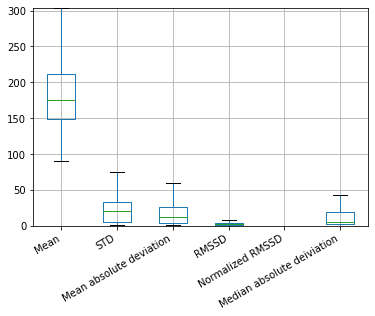

In [43]:
fig, ax = plt.subplots()
box = df5.boxplot(column=['Mean', 'STD', 'Mean absolute deviation', 'RMSSD', 'Normalized RMSSD', 'Median absolute deiviation'], ax=ax, sym='', figsize=(4,3)) 
ax.margins(y=0)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## (7.2) Scores

In [44]:
print(f"SVM Scores: {cv_svm_results['test_score']}")
print(f"Mean: {np.mean(cv_svm_results['test_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_score']}")
print(f"Mean: {np.mean(cv_dt_results['test_score'])}")
print()
print(f"Random forest: {cv_rf_results['test_score']}")
print(f"Mean: {np.mean(cv_rf_results['test_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['test_score']}")
print(f"Mean: {np.mean(cv_stacking_results['test_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['test_score']}")
print(f"Mean: {np.mean(cv_xgb_results['test_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['test_score']}")
print(f"Mean: {np.mean(cv_ab_results['test_score'])}")
print("-------------------------------(Testing scores above)------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("-------------------------------(Training scores below)-----------------------------------------------------")
print(f"SVM Scores: {cv_svm_results['train_score']}")
print(f"Mean: {np.mean(cv_svm_results['train_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['train_score']}")
print(f"Mean: {np.mean(cv_dt_results['train_score'])}")
print()
print(f"Random forest: {cv_rf_results['train_score']}")
print(f"Mean: {np.mean(cv_rf_results['train_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['train_score']}")
print(f"Mean: {np.mean(cv_stacking_results['train_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['train_score']}")
print(f"Mean: {np.mean(cv_xgb_results['train_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['train_score']}")
print(f"Mean: {np.mean(cv_ab_results['train_score'])}")

SVM Scores: [0.94623201 0.90431837 0.93734124 0.91024555 0.95595087]
Mean: 0.9308176080328769

Decision tree Scores: [0.95173582 0.90220152 0.94665538 0.93988146 0.93265565]
Mean: 0.9346259657624373

Random forest: [0.957663   0.91490262 0.95681626 0.95723963 0.9656925 ]
Mean: 0.9504628020747822

Stacking classifier Scores: [0.95808637 0.91913633 0.95427604 0.96316681 0.96442186]
Mean: 0.9518174785652113

xgboost Scores: [0.95427604 0.90050804 0.95300593 0.94157494 0.96442186]
Mean: 0.9427573600216043

AdaBoost Scores: [0.95385267 0.91701948 0.95681626 0.95808637 0.95722152]
Mean: 0.9485992566906271
-------------------------------(Testing scores above)------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-------------------------------(Training scores below)-----------------------------------------------------
SVM Scores: [0.94093363 0.94707314 0.94357997 0.94548534 0.93755292]


## (7.3) Evaluate on addtional Databases (Normal Sinus Rhythm Database, Arrhythmia and Long Term AF)

In [45]:
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

clf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
adaBoost_clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

In [46]:
print("-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_nsr, y_nsr)}")
print(f"DT: {pipeline_dt.score(X_nsr, y_nsr)}")
print(f"RF: {pipeline_rf.score(X_nsr, y_nsr)}")
print(f"Stacking: {clf.score(X_nsr, y_nsr)}")
print(f"Xgbost: {xgb_model.score(X_nsr, y_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_nsr, y_nsr)}")
print("-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_A, y_A)}")
print(f"DT: {pipeline_dt.score(X_A, y_A)}")
print(f"RF: {pipeline_rf.score(X_A, y_A)}")
print(f"Stacking: {clf.score(X_A, y_A)}")
print(f"Xgbost: {xgb_model.score(X_A, y_A)}")
print(f"AdaBoost: {adaBoost_clf.score(X_A, y_A)}")
print("-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_long, y_long)}")
print(f"DT: {pipeline_dt.score(X_long, y_long)}")
print(f"RF: {pipeline_rf.score(X_long, y_long)}")
print(f"Stacking: {clf.score(X_long, y_long)}")
print(f"Xgbost: {xgb_model.score(X_long, y_long)}")
print(f"AdaBoost: {adaBoost_clf.score(X_long, y_long)}")

-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------
SVM: 0.9630392189419852
DT: 0.9694816192342178
RF: 0.9684521635174177
Stacking: 0.979477302161857
Xgbost: 0.9666921263241789
AdaBoost: 0.9694816192342178


-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------
SVM: 0.7982860909690178
DT: 0.8576137112722478
RF: 0.8721160184574819
Stacking: 0.8800263678312459
Xgbost: 0.8681608437705999
AdaBoost: 0.8213579433091628


## (7.4) Classification reports and Precision recall curve

In [50]:
from sklearn.metrics import classification_report

In [48]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_stacking = clf.predict(X_test)
y_pred_xgboost = xgb_model.predict(X_test)
y_pred_adaboost = adaBoost_clf.predict(X_test)

In [51]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("AFIB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

SVM below:
              precision    recall  f1-score   support

     class 0       0.97      0.96      0.96      1523
     class 1       0.92      0.94      0.93       839

    accuracy                           0.95      2362
   macro avg       0.94      0.95      0.95      2362
weighted avg       0.95      0.95      0.95      2362

DT below:
              precision    recall  f1-score   support

     class 0       0.97      0.97      0.97      1523
     class 1       0.94      0.94      0.94       839

    accuracy                           0.96      2362
   macro avg       0.96      0.96      0.96      2362
weighted avg       0.96      0.96      0.96      2362

RF below:
              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98      1523
     class 1       0.96      0.97      0.96       839

    accuracy                           0.97      2362
   macro avg       0.97      0.97      0.97      2362
weighted avg       0.97      0.97      0.97

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("MITDB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("NSRDB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

In [ ]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("LONG TERM AF DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

In [52]:
from sklearn.metrics import precision_recall_curve

In [53]:
y_score_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_score_dt = pipeline_dt.predict_proba(X_test)[:, 1]
y_score_rf = pipeline_rf.predict_proba(X_test)[:, 1]

y_score_stacking = clf.predict_proba(X_test)[:, 1]
y_score_xgboost = xgb_model.predict_proba(X_test)[:, 1]
y_score_adaboost = adaBoost_clf.predict_proba(X_test)[:, 1]

In [54]:
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_score_svm)
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_score_dt)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)

precision_stacking, recall_stacking, thresholds_stacking = precision_recall_curve(y_test, y_score_stacking)
precision_xgboost, recall_xgboost, thresholds_xgboost = precision_recall_curve(y_test, y_score_xgboost)
precision_adaboost, recall_adaboost, thresholds_adaboost = precision_recall_curve(y_test, y_score_adaboost)

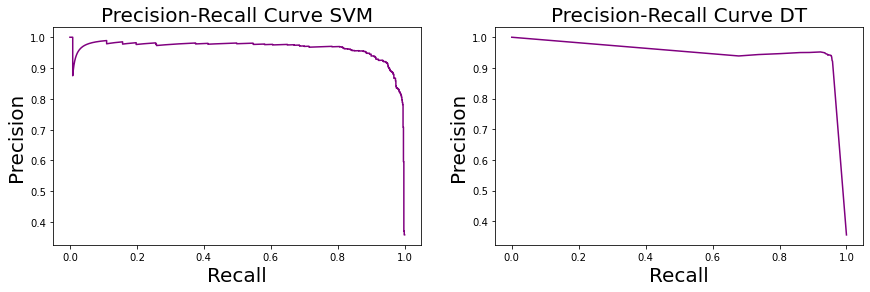

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_svm, precision_svm, color='purple')
ax1.set_title('Precision-Recall Curve SVM', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_dt, precision_dt, color='purple')
ax2.set_title('Precision-Recall Curve DT', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

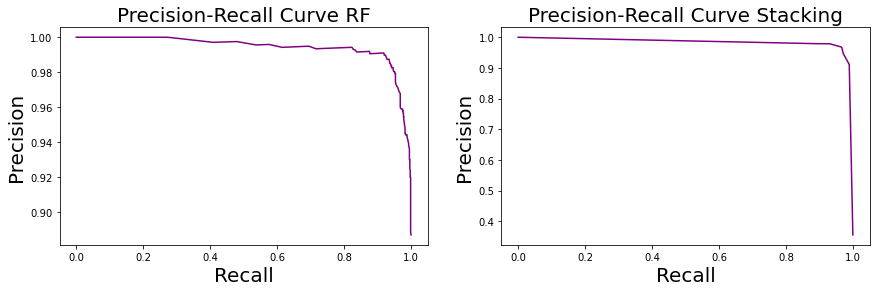

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_rf, precision_rf, color='purple')
ax1.set_title('Precision-Recall Curve RF', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_stacking, precision_stacking, color='purple')
ax2.set_title('Precision-Recall Curve Stacking', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

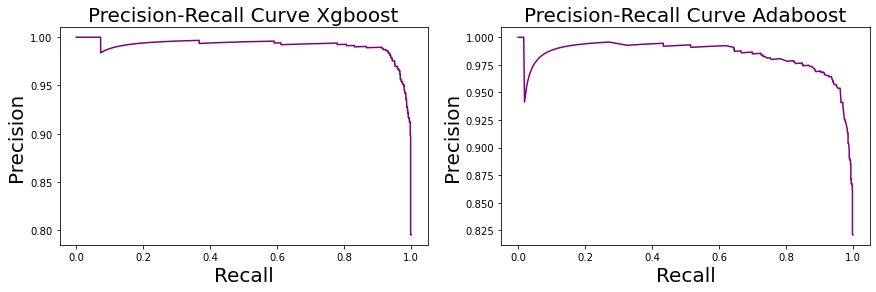

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_xgboost, precision_xgboost, color='purple')
ax1.set_title('Precision-Recall Curve Xgboost', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_adaboost, precision_adaboost, color='purple')
ax2.set_title('Precision-Recall Curve Adaboost', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

# (8) RESULTS FOR SEGMENT LENGTH = 20

## (8.1) Feature results

In [40]:
df5 = pd.DataFrame(all_features)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD,Shannon Entropy,Mean absolute deviation,Median absolute deiviation
0,168.25,43.226,1.115,0.007,1.000,39.700,27.5
1,169.10,50.353,1.126,0.007,0.977,47.210,55.0
2,150.75,62.874,1.669,0.011,0.977,50.850,29.0
3,194.20,32.262,1.038,0.005,0.931,27.120,17.0
4,169.85,43.731,1.013,0.006,0.977,41.550,37.5
...,...,...,...,...,...,...,...
35423,189.30,2.326,0.052,0.000,0.690,1.930,2.0
35424,188.80,2.272,0.048,0.000,0.617,2.000,2.0
35425,188.00,2.000,0.056,0.000,0.634,1.500,1.0
35426,187.85,1.621,0.051,0.000,0.598,1.265,1.0


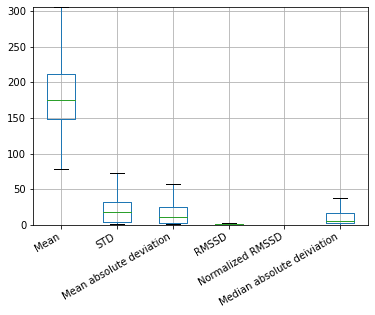

In [41]:
fig, ax = plt.subplots()
box = df5.boxplot(column=['Mean', 'STD', 'Mean absolute deviation', 'RMSSD', 'Normalized RMSSD', 'Median absolute deiviation'], ax=ax, sym='', figsize=(4,3)) 
ax.margins(y=0)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## (8.2) Scores

In [42]:
print(f"SVM Scores: {cv_svm_results['test_score']}")
print(f"Mean: {np.mean(cv_svm_results['test_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_score']}")
print(f"Mean: {np.mean(cv_dt_results['test_score'])}")
print()
print(f"Random forest: {cv_rf_results['test_score']}")
print(f"Mean: {np.mean(cv_rf_results['test_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['test_score']}")
print(f"Mean: {np.mean(cv_stacking_results['test_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['test_score']}")
print(f"Mean: {np.mean(cv_xgb_results['test_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['test_score']}")
print(f"Mean: {np.mean(cv_ab_results['test_score'])}")
print("-------------------------------(Testing scores above)------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("-------------------------------(Training scores below)-----------------------------------------------------")
print(f"SVM Scores: {cv_svm_results['train_score']}")
print(f"Mean: {np.mean(cv_svm_results['train_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['train_score']}")
print(f"Mean: {np.mean(cv_dt_results['train_score'])}")
print()
print(f"Random forest: {cv_rf_results['train_score']}")
print(f"Mean: {np.mean(cv_rf_results['train_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['train_score']}")
print(f"Mean: {np.mean(cv_stacking_results['train_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['train_score']}")
print(f"Mean: {np.mean(cv_xgb_results['train_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['train_score']}")
print(f"Mean: {np.mean(cv_ab_results['train_score'])}")

SVM Scores: [0.94609088 0.88470223 0.93395428 0.90105857 0.91813691]
Mean: 0.9167885745267688

Decision tree Scores: [0.94623201 0.89796782 0.93578888 0.92279464 0.90486944]
Mean: 0.9215305578345763

Random forest: [0.95004234 0.92125318 0.9449619  0.9298518  0.92350035]
Mean: 0.9339219122820334

Stacking classifier Scores: [0.95215919 0.91447925 0.9449619  0.93465067 0.92279464]
Mean: 0.9338091291365224

xgboost Scores: [0.94877223 0.91744285 0.9443974  0.92307692 0.92110092]
Mean: 0.9309580631623062

AdaBoost Scores: [0.95018346 0.90897544 0.94044595 0.92194778 0.90825688]
Mean: 0.9259619024741103
-------------------------------(Testing scores above)------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-------------------------------(Training scores below)-----------------------------------------------------
SVM Scores: [0.9210712  0.93444358 0.92290593 0.92876548 0.92502558]


## (8.3) Evaluate on addtional Databases (Normal Sinus Rhythm Database, Arrhythmia and Long Term AF)

In [43]:
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

clf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
adaBoost_clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:07:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

In [44]:
print("-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_nsr, y_nsr)}")
print(f"DT: {pipeline_dt.score(X_nsr, y_nsr)}")
print(f"RF: {pipeline_rf.score(X_nsr, y_nsr)}")
print(f"Stacking: {clf.score(X_nsr, y_nsr)}")
print(f"Xgbost: {xgb_model.score(X_nsr, y_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_nsr, y_nsr)}")
print("-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_A, y_A)}")
print(f"DT: {pipeline_dt.score(X_A, y_A)}")
print(f"RF: {pipeline_rf.score(X_A, y_A)}")
print(f"Stacking: {clf.score(X_A, y_A)}")
print(f"Xgbost: {xgb_model.score(X_A, y_A)}")
print(f"AdaBoost: {adaBoost_clf.score(X_A, y_A)}")
print("-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_long, y_long)}")
print(f"DT: {pipeline_dt.score(X_long, y_long)}")
print(f"RF: {pipeline_rf.score(X_long, y_long)}")
print(f"Stacking: {clf.score(X_long, y_long)}")
print(f"Xgbost: {xgb_model.score(X_long, y_long)}")
print(f"AdaBoost: {adaBoost_clf.score(X_long, y_long)}")

-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------
SVM: 0.9508960692502685
DT: 0.9011279735219562
RF: 0.9501654877738297
Stacking: 0.962220082135069
Xgbost: 0.9573716777914301
AdaBoost: 0.9354874417471967


-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------
SVM: 0.7961335676625659
DT: 0.8416080843585237
RF: 0.8567662565905096
Stacking: 0.8741212653778558
Xgbost: 0.8651142355008787
AdaBoost: 0.8574253075571178
-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------
SVM: 0.8091377260476788
DT: 0.805006938057408
RF: 0.7928421039138335
Stacking: 0.7594657215099008
Xgbost: 0.7018686287642567
AdaBoost: 0.8559031171586332


## (8.4) Classification reports and Precision recall curve

In [45]:
from sklearn.metrics import classification_report

In [46]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_stacking = clf.predict(X_test)
y_pred_xgboost = xgb_model.predict(X_test)
y_pred_adaboost = adaBoost_clf.predict(X_test)

In [47]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("AFIB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

AFIB DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.95      0.93      0.94      4472
     class 1       0.88      0.92      0.90      2614

    accuracy                           0.92      7086
   macro avg       0.92      0.92      0.92      7086
weighted avg       0.92      0.92      0.92      7086

DT below:
              precision    recall  f1-score   support

     class 0       0.96      0.95      0.96      4472
     class 1       0.91      0.94      0.92      2614

    accuracy                           0.94      7086
   macro avg       0.94      0.94      0.94      7086
weighted avg       0.94      0.94      0.94      7086

RF below:
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4472
     class 1       0.92      0.94      0.93      2614

    accuracy                           0.95      7086
   macro avg       0.94      0.95      0.95      7086
weighted avg       0.95    

In [48]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("MITDB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

MITDB DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.95      0.93      0.94      4472
     class 1       0.88      0.92      0.90      2614

    accuracy                           0.92      7086
   macro avg       0.92      0.92      0.92      7086
weighted avg       0.92      0.92      0.92      7086

DT below:
              precision    recall  f1-score   support

     class 0       0.96      0.95      0.96      4472
     class 1       0.91      0.94      0.92      2614

    accuracy                           0.94      7086
   macro avg       0.94      0.94      0.94      7086
weighted avg       0.94      0.94      0.94      7086

RF below:
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4472
     class 1       0.92      0.94      0.93      2614

    accuracy                           0.95      7086
   macro avg       0.94      0.95      0.95      7086
weighted avg       0.95   

In [49]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("NSRDB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

NSRDB DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.95      0.93      0.94      4472
     class 1       0.88      0.92      0.90      2614

    accuracy                           0.92      7086
   macro avg       0.92      0.92      0.92      7086
weighted avg       0.92      0.92      0.92      7086

DT below:
              precision    recall  f1-score   support

     class 0       0.96      0.95      0.96      4472
     class 1       0.91      0.94      0.92      2614

    accuracy                           0.94      7086
   macro avg       0.94      0.94      0.94      7086
weighted avg       0.94      0.94      0.94      7086

RF below:
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4472
     class 1       0.92      0.94      0.93      2614

    accuracy                           0.95      7086
   macro avg       0.94      0.95      0.95      7086
weighted avg       0.95   

In [50]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("LONG TERM AF DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

LONG TERM AF DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.95      0.93      0.94      4472
     class 1       0.88      0.92      0.90      2614

    accuracy                           0.92      7086
   macro avg       0.92      0.92      0.92      7086
weighted avg       0.92      0.92      0.92      7086

DT below:
              precision    recall  f1-score   support

     class 0       0.96      0.95      0.96      4472
     class 1       0.91      0.94      0.92      2614

    accuracy                           0.94      7086
   macro avg       0.94      0.94      0.94      7086
weighted avg       0.94      0.94      0.94      7086

RF below:
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4472
     class 1       0.92      0.94      0.93      2614

    accuracy                           0.95      7086
   macro avg       0.94      0.95      0.95      7086
weighted avg       

In [51]:
from sklearn.metrics import precision_recall_curve

In [52]:
y_score_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_score_dt = pipeline_dt.predict_proba(X_test)[:, 1]
y_score_rf = pipeline_rf.predict_proba(X_test)[:, 1]

y_score_stacking = clf.predict_proba(X_test)[:, 1]
y_score_xgboost = xgb_model.predict_proba(X_test)[:, 1]
y_score_adaboost = adaBoost_clf.predict_proba(X_test)[:, 1]

In [53]:
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_score_svm)
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_score_dt)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)

precision_stacking, recall_stacking, thresholds_stacking = precision_recall_curve(y_test, y_score_stacking)
precision_xgboost, recall_xgboost, thresholds_xgboost = precision_recall_curve(y_test, y_score_xgboost)
precision_adaboost, recall_adaboost, thresholds_adaboost = precision_recall_curve(y_test, y_score_adaboost)

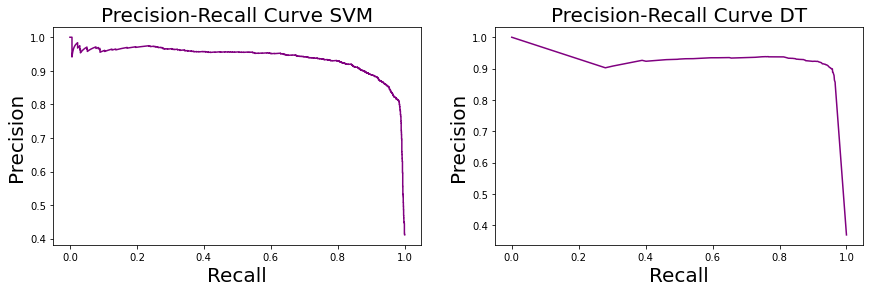

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_svm, precision_svm, color='purple')
ax1.set_title('Precision-Recall Curve SVM', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_dt, precision_dt, color='purple')
ax2.set_title('Precision-Recall Curve DT', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

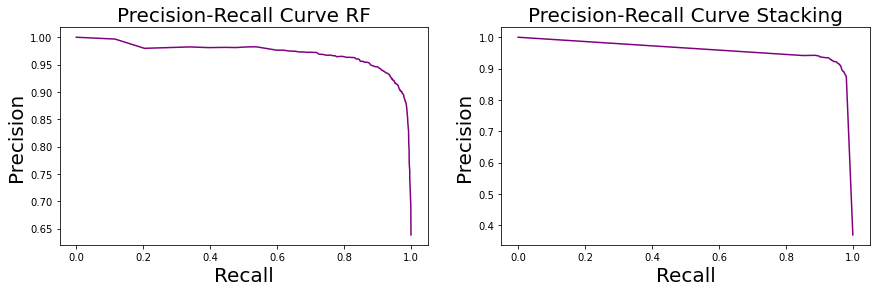

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_rf, precision_rf, color='purple')
ax1.set_title('Precision-Recall Curve RF', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_stacking, precision_stacking, color='purple')
ax2.set_title('Precision-Recall Curve Stacking', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

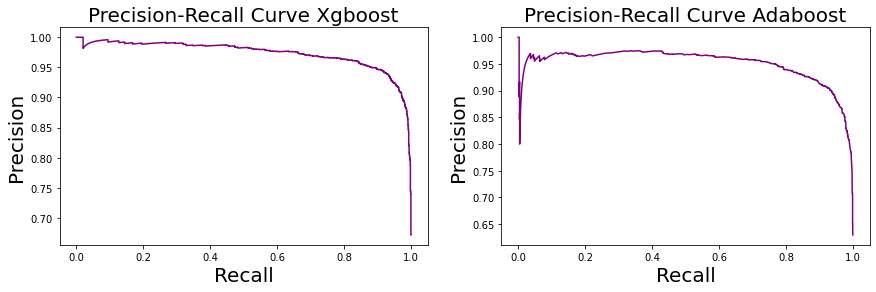

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_xgboost, precision_xgboost, color='purple')
ax1.set_title('Precision-Recall Curve Xgboost', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_adaboost, precision_adaboost, color='purple')
ax2.set_title('Precision-Recall Curve Adaboost', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

# (9) RESULTS FOR SEGMENT LENGTH = 10

## (9.1) Feature results

In [41]:
df5 = pd.DataFrame(all_features)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD,Shannon Entropy,Mean absolute deviation,Median absolute deiviation
0,179.4,40.255,0.718,0.004,1.000,38.68,12.0
1,157.1,43.219,0.324,0.002,1.000,40.72,30.5
2,193.7,42.507,0.733,0.004,1.000,40.56,23.0
3,144.5,45.317,0.311,0.002,1.000,39.10,31.5
4,110.0,25.144,0.441,0.004,0.940,19.80,13.0
...,...,...,...,...,...,...,...
70851,187.0,1.844,0.032,0.000,0.556,1.60,1.0
70852,187.5,1.432,0.020,0.000,0.699,1.20,1.0
70853,188.2,1.720,0.029,0.000,0.699,1.44,1.0
70854,188.5,2.291,0.035,0.000,0.880,1.90,1.5


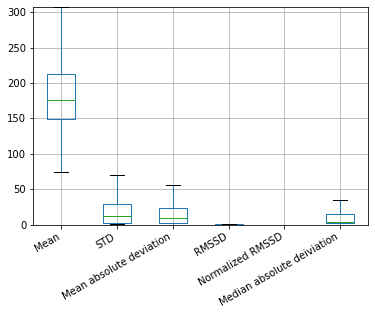

In [42]:
fig, ax = plt.subplots()
box = df5.boxplot(column=['Mean', 'STD', 'Mean absolute deviation', 'RMSSD', 'Normalized RMSSD', 'Median absolute deiviation'], ax=ax, sym='', figsize=(4,3)) 
ax.margins(y=0)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## (9.2) Scores

In [43]:
print(f"SVM Scores: {cv_svm_results['test_score']}")
print(f"Mean: {np.mean(cv_svm_results['test_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_score']}")
print(f"Mean: {np.mean(cv_dt_results['test_score'])}")
print()
print(f"Random forest: {cv_rf_results['test_score']}")
print(f"Mean: {np.mean(cv_rf_results['test_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['test_score']}")
print(f"Mean: {np.mean(cv_stacking_results['test_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['test_score']}")
print(f"Mean: {np.mean(cv_xgb_results['test_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['test_score']}")
print(f"Mean: {np.mean(cv_ab_results['test_score'])}")
print("-------------------------------(Testing scores above)------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("-------------------------------(Training scores below)-----------------------------------------------------")
print(f"SVM Scores: {cv_svm_results['train_score']}")
print(f"Mean: {np.mean(cv_svm_results['train_score'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['train_score']}")
print(f"Mean: {np.mean(cv_dt_results['train_score'])}")
print()
print(f"Random forest: {cv_rf_results['train_score']}")
print(f"Mean: {np.mean(cv_rf_results['train_score'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['train_score']}")
print(f"Mean: {np.mean(cv_stacking_results['train_score'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['train_score']}")
print(f"Mean: {np.mean(cv_xgb_results['train_score'])}")
print()
print(f"AdaBoost Scores: {cv_ab_results['train_score']}")
print(f"Mean: {np.mean(cv_ab_results['train_score'])}")

SVM Scores: [0.9374118  0.85936067 0.92110649 0.87629666 0.88610543]
Mean: 0.8960562075817103

Decision tree Scores: [0.92873271 0.90600522 0.92138875 0.87904876 0.87079246]
Mean: 0.90119358220715

Random forest: [0.94291561 0.91242679 0.92717522 0.89633759 0.88292993]
Mean: 0.9123570261010763

Stacking classifier Scores: [0.94178662 0.90078329 0.92738692 0.89951309 0.88483523]
Mean: 0.910861029050575

xgboost Scores: [0.94030483 0.91454379 0.92449368 0.88970433 0.88215369]
Mean: 0.9102400634418684

AdaBoost Scores: [0.94362122 0.90191236 0.92456425 0.89944252 0.88067179]
Mean: 0.9100424300158781
-------------------------------(Testing scores above)------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-------------------------------(Training scores below)-----------------------------------------------------
SVM Scores: [0.89402653 0.91027609 0.89912675 0.90738291 0.90646556]
Mea

## (9.3) Evaluate on addtional Databases (Normal Sinus Rhythm Database, Arrhythmia and Long Term AF)

In [44]:
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

clf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
adaBoost_clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

In [45]:
print("-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_nsr, y_nsr)}")
print(f"DT: {pipeline_dt.score(X_nsr, y_nsr)}")
print(f"RF: {pipeline_rf.score(X_nsr, y_nsr)}")
print(f"Stacking: {clf.score(X_nsr, y_nsr)}")
print(f"Xgbost: {xgb_model.score(X_nsr, y_nsr)}")
print(f"AdaBoost: {adaBoost_clf.score(X_nsr, y_nsr)}")
print("-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_A, y_A)}")
print(f"DT: {pipeline_dt.score(X_A, y_A)}")
print(f"RF: {pipeline_rf.score(X_A, y_A)}")
print(f"Stacking: {clf.score(X_A, y_A)}")
print(f"Xgbost: {xgb_model.score(X_A, y_A)}")
print(f"AdaBoost: {adaBoost_clf.score(X_A, y_A)}")
print("-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------")
print(f"SVM: {pipeline_svm.score(X_long, y_long)}")
print(f"DT: {pipeline_dt.score(X_long, y_long)}")
print(f"RF: {pipeline_rf.score(X_long, y_long)}")
print(f"Stacking: {clf.score(X_long, y_long)}")
print(f"Xgbost: {xgb_model.score(X_long, y_long)}")
print(f"AdaBoost: {adaBoost_clf.score(X_long, y_long)}")

-------------------------------(Testing scores below for Normal sinus Rhythm DB)-----------------------------------------------
SVM: 0.900082466695078
DT: 0.8741691065370076
RF: 0.9295601591773255
Stacking: 0.9440776183175688
Xgbost: 0.9407125343841841
AdaBoost: 0.9174060073389824


-------------------------------(Testing scores below for Arrhythmia DB)-----------------------------------------------
SVM: 0.7665861159929701
DT: 0.8075571177504394
RF: 0.8413884007029877
Stacking: 0.8353471001757469
Xgbost: 0.812609841827768
AdaBoost: 0.8256810193321616
-------------------------------(Testing scores below for Long term AF DB)---------------------------------------------
SVM: 0.8545606037542361
DT: 0.8661918457927078
RF: 0.8711830730898341
Stacking: 0.8604763697834464
Xgbost: 0.8291526129836002
AdaBoost: 0.8497584502359417


## (9.4) Classification reports and Precision recall curve

In [51]:
from sklearn.metrics import classification_report

In [46]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_stacking = clf.predict(X_test)
y_pred_xgboost = xgb_model.predict(X_test)
y_pred_adaboost = adaBoost_clf.predict(X_test)

In [47]:
y_pred_svm_nsr = pipeline_svm.predict(X_test_nsr)
y_pred_dt_nsr = pipeline_dt.predict(X_test_nsr)
y_pred_rf_nsr = pipeline_rf.predict(X_test_nsr)
y_pred_stacking_nsr = clf.predict(X_test_nsr)
y_pred_xgboost_nsr = xgb_model.predict(X_test_nsr)
y_pred_adaboost_nsr = adaBoost_clf.predict(X_test_nsr)

In [48]:
y_pred_svm_A = pipeline_svm.predict(X_test_A)
y_pred_dt_A = pipeline_dt.predict(X_test_A)
y_pred_rf_A = pipeline_rf.predict(X_test_A)
y_pred_stacking_A = clf.predict(X_test_A)
y_pred_xgboost_A = xgb_model.predict(X_test_A)
y_pred_adaboost_A = adaBoost_clf.predict(X_test_A)

In [49]:
y_pred_svm_long = pipeline_svm.predict(X_test_long)
y_pred_dt_long = pipeline_dt.predict(X_test_long)
y_pred_rf_long = pipeline_rf.predict(X_test_long)
y_pred_stacking_long = clf.predict(X_test_long)
y_pred_xgboost_long = xgb_model.predict(X_test_long)
y_pred_adaboost_long = adaBoost_clf.predict(X_test_long)

In [52]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("AFIB DATA BELOW")
print("SVM below:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print("DT below:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print("RF below:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test, y_pred_stacking, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test, y_pred_xgboost, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test, y_pred_adaboost, target_names=target_names))

AFIB DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.94      0.90      0.92      8987
     class 1       0.84      0.91      0.87      5185

    accuracy                           0.90     14172
   macro avg       0.89      0.90      0.90     14172
weighted avg       0.91      0.90      0.90     14172

DT below:
              precision    recall  f1-score   support

     class 0       0.96      0.92      0.94      8987
     class 1       0.87      0.93      0.90      5185

    accuracy                           0.93     14172
   macro avg       0.92      0.93      0.92     14172
weighted avg       0.93      0.93      0.93     14172

RF below:
              precision    recall  f1-score   support

     class 0       0.97      0.94      0.95      8987
     class 1       0.90      0.94      0.92      5185

    accuracy                           0.94     14172
   macro avg       0.93      0.94      0.94     14172
weighted avg       0.94    

In [53]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("NSRDB DATA BELOW")
print("SVM below:")
print(classification_report(y_test_nsr, y_pred_svm_nsr, target_names=target_names))
print("DT below:")
print(classification_report(y_test_nsr, y_pred_dt_nsr, target_names=target_names))
print("RF below:")
print(classification_report(y_test_nsr, y_pred_rf_nsr, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test_nsr, y_pred_stacking_nsr, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test_nsr, y_pred_xgboost_nsr, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test_nsr, y_pred_adaboost_nsr, target_names=target_names))

NSRDB DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       1.00      0.90      0.95     36136
     class 1       0.00      0.00      0.00         0

    accuracy                           0.90     36136
   macro avg       0.50      0.45      0.47     36136
weighted avg       1.00      0.90      0.95     36136

DT below:
              precision    recall  f1-score   support

     class 0       1.00      0.87      0.93     36136
     class 1       0.00      0.00      0.00         0

    accuracy                           0.87     36136
   macro avg       0.50      0.44      0.47     36136
weighted avg       1.00      0.87      0.93     36136

RF below:


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are 

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     36136
     class 1       0.00      0.00      0.00         0

    accuracy                           0.93     36136
   macro avg       0.50      0.46      0.48     36136
weighted avg       1.00      0.93      0.96     36136

Stacking below:
              precision    recall  f1-score   support

     class 0       1.00      0.94      0.97     36136
     class 1       0.00      0.00      0.00         0

    accuracy                           0.94     36136
   macro avg       0.50      0.47      0.48     36136
weighted avg       1.00      0.94      0.97     36136

Xgboost below:
              precision    recall  f1-score   support

     class 0       1.00      0.94      0.97     36136
     class 1       0.00      0.00      0.00         0

    accuracy                           0.94     36136
   macro avg       0.50      0.47      0.48     36136
weighted avg       1.00      0.94      0.97

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("Arrhythmia DATA BELOW")
print("SVM below:")
print(classification_report(y_test_A, y_pred_svm_A, target_names=target_names))
print("DT below:")
print(classification_report(y_test_A, y_pred_dt_A, target_names=target_names))
print("RF below:")
print(classification_report(y_test_A, y_pred_rf_A, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test_A, y_pred_stacking_A, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test_A, y_pred_xgboost_A, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test_A, y_pred_adaboost_A, target_names=target_names))

Arrhythmia DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.97      0.75      0.85      1588
     class 1       0.34      0.86      0.49       233

    accuracy                           0.77      1821
   macro avg       0.66      0.81      0.67      1821
weighted avg       0.89      0.77      0.80      1821

DT below:
              precision    recall  f1-score   support

     class 0       0.90      0.88      0.89      1588
     class 1       0.31      0.36      0.34       233

    accuracy                           0.81      1821
   macro avg       0.61      0.62      0.61      1821
weighted avg       0.83      0.81      0.82      1821

RF below:
              precision    recall  f1-score   support

     class 0       0.95      0.87      0.91      1588
     class 1       0.44      0.70      0.54       233

    accuracy                           0.85      1821
   macro avg       0.70      0.78      0.72      1821
weighted avg       0.

In [55]:
target_names = ['class 0', 'class 1'] # class 0 = Normal rythm, class 1 = AFIB
print("LONG TERM AF DATA BELOW")
print("SVM below:")
print(classification_report(y_test_long, y_pred_svm_long, target_names=target_names))
print("DT below:")
print(classification_report(y_test_long, y_pred_dt_long, target_names=target_names))
print("RF below:")
print(classification_report(y_test_long, y_pred_rf_long, target_names=target_names))
print("Stacking below:")
print(classification_report(y_test_long, y_pred_stacking_long, target_names=target_names))
print("Xgboost below:")
print(classification_report(y_test_long, y_pred_xgboost_long, target_names=target_names))
print("Adaboost below:")
print(classification_report(y_test_long, y_pred_adaboost_long, target_names=target_names))

LONG TERM AF DATA BELOW
SVM below:
              precision    recall  f1-score   support

     class 0       0.82      0.88      0.85     58373
     class 1       0.89      0.83      0.86     66446

    accuracy                           0.85    124819
   macro avg       0.85      0.86      0.85    124819
weighted avg       0.86      0.85      0.85    124819

DT below:
              precision    recall  f1-score   support

     class 0       0.83      0.89      0.86     58373
     class 1       0.90      0.84      0.87     66446

    accuracy                           0.87    124819
   macro avg       0.87      0.87      0.87    124819
weighted avg       0.87      0.87      0.87    124819

RF below:
              precision    recall  f1-score   support

     class 0       0.83      0.92      0.87     58373
     class 1       0.92      0.83      0.87     66446

    accuracy                           0.87    124819
   macro avg       0.87      0.87      0.87    124819
weighted avg       

In [56]:
from sklearn.metrics import precision_recall_curve

In [57]:
y_score_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_score_dt = pipeline_dt.predict_proba(X_test)[:, 1]
y_score_rf = pipeline_rf.predict_proba(X_test)[:, 1]

y_score_stacking = clf.predict_proba(X_test)[:, 1]
y_score_xgboost = xgb_model.predict_proba(X_test)[:, 1]
y_score_adaboost = adaBoost_clf.predict_proba(X_test)[:, 1]

In [58]:
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_score_svm)
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_score_dt)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)

precision_stacking, recall_stacking, thresholds_stacking = precision_recall_curve(y_test, y_score_stacking)
precision_xgboost, recall_xgboost, thresholds_xgboost = precision_recall_curve(y_test, y_score_xgboost)
precision_adaboost, recall_adaboost, thresholds_adaboost = precision_recall_curve(y_test, y_score_adaboost)

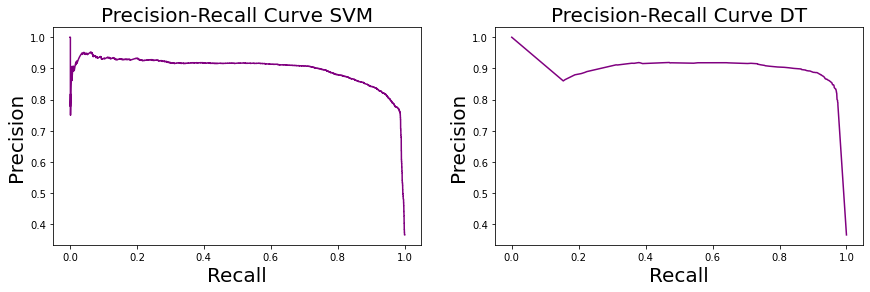

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_svm, precision_svm, color='purple')
ax1.set_title('Precision-Recall Curve SVM', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_dt, precision_dt, color='purple')
ax2.set_title('Precision-Recall Curve DT', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

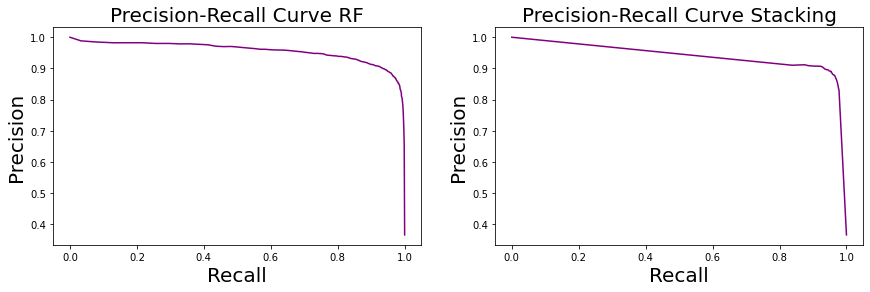

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_rf, precision_rf, color='purple')
ax1.set_title('Precision-Recall Curve RF', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_stacking, precision_stacking, color='purple')
ax2.set_title('Precision-Recall Curve Stacking', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

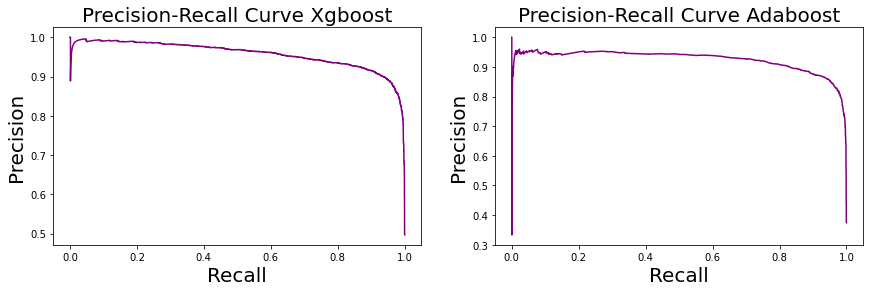

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(recall_xgboost, precision_xgboost, color='purple')
ax1.set_title('Precision-Recall Curve Xgboost', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.set_xlabel('Recall', fontsize=20)

plt.subplots_adjust(right = 2)

ax2.plot(recall_adaboost, precision_adaboost, color='purple')
ax2.set_title('Precision-Recall Curve Adaboost', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.set_xlabel('Recall', fontsize=20)
plt.show()

# (10) Confusion Matrices

In [57]:
from sklearn.metrics import confusion_matrix

y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_stacking = clf.predict(X_test)
y_pred_xgboost = xgb_model.predict(X_test)
y_pred_adaboost = adaBoost_clf.predict(X_test)


cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
target_names = ['Normal', 'AFIB']

##### (reminder) below cell is confusion matrices for arrhythmia data (trained on afib data)

In [58]:
y_pred_svm_A = pipeline_svm.predict(X_A)
y_pred_dt_A = pipeline_dt.predict(X_A)
y_pred_rf_A = pipeline_rf.predict(X_A)
y_pred_stacking_A = clf.predict(X_A)
y_pred_xgboost_A = xgb_model.predict(X_A)
y_pred_adaboost_A = adaBoost_clf.predict(X_A)


cm_svm_A = confusion_matrix(y_A, y_pred_svm_A)
cm_dt_A = confusion_matrix(y_A, y_pred_dt_A)
cm_rf_A = confusion_matrix(y_A, y_pred_rf_A)
cm_stacking_A = confusion_matrix(y_A, y_pred_stacking_A)
cm_xgboost_A = confusion_matrix(y_A, y_pred_xgboost_A)
cm_adaboost_A = confusion_matrix(y_A, y_pred_adaboost_A)
target_names_A = ['Normal', 'AFIB']

In [59]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=15)
        plt.yticks(tick_marks, target_names, fontsize=15)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     fontsize=20, #####
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label'.format(accuracy, misclass), fontsize=20) #\naccuracy={:0.2f}; misclass={:0.2f}
    plt.show()

## (10.1) RESULTS FOR SEGMENT LENGTH = 60

#### CM SVM (AFIB data)

#### CM DT (AFIB data)

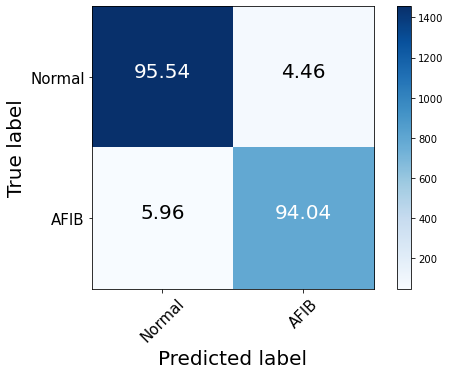

In [66]:
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

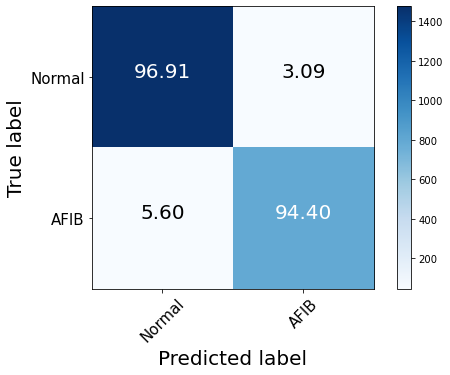

In [67]:
plot_confusion_matrix(cm=cm_dt, target_names=target_names)

#### CM RandomForest (AFIB data)

#### CM Stacking (AFIB data)

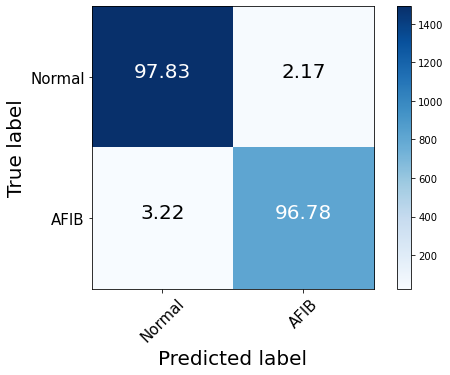

In [68]:
plot_confusion_matrix(cm=cm_rf, target_names=target_names)

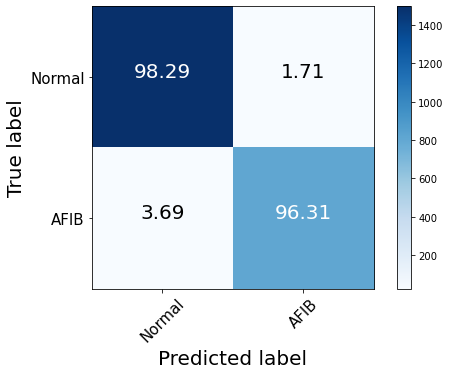

In [69]:
plot_confusion_matrix(cm=cm_stacking, target_names=target_names)

#### CM XGBoost (AFIB data)

#### CM AdaBoost (AFIB data)

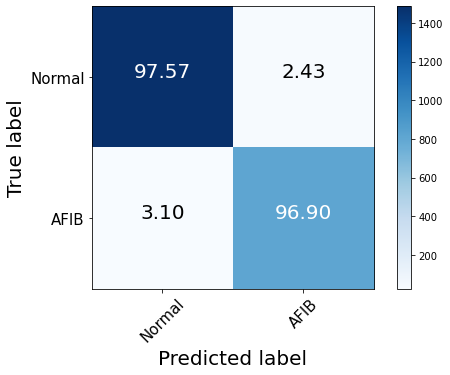

In [70]:
plot_confusion_matrix(cm=cm_xgboost, target_names=target_names)

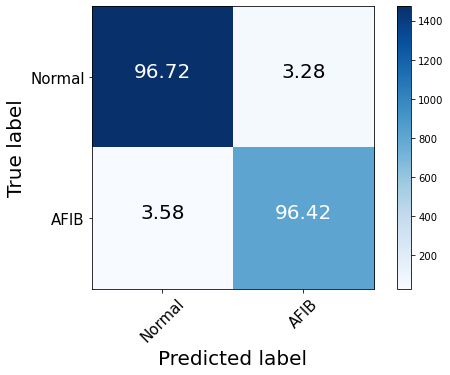

In [71]:
plot_confusion_matrix(cm=cm_adaboost, target_names=target_names)

#### CM SVM (Arrhythmia data)

#### CM DT (Arrhythmia data)

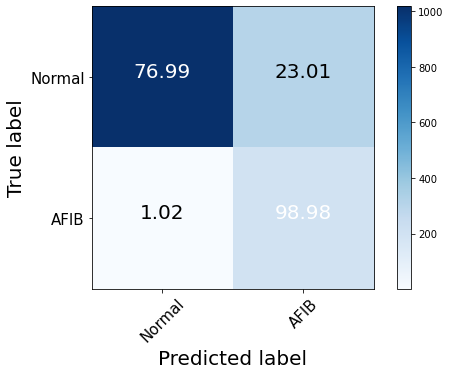

In [74]:
plot_confusion_matrix(cm=cm_svm_A, target_names=target_names_A)

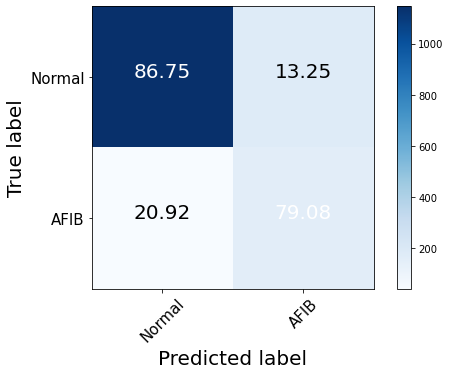

In [75]:
plot_confusion_matrix(cm=cm_dt_A, target_names=target_names_A)

#### CM RF (Arrhythmia data)

#### CM STACKING (Arrhythmia data)

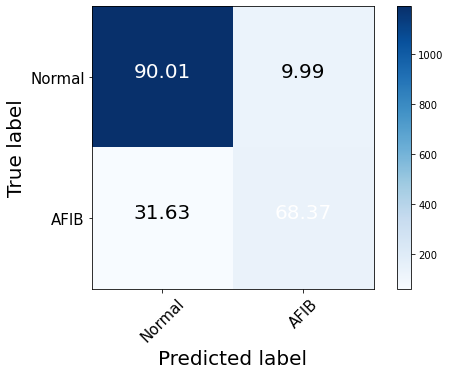

In [76]:
plot_confusion_matrix(cm=cm_rf_A, target_names=target_names_A)

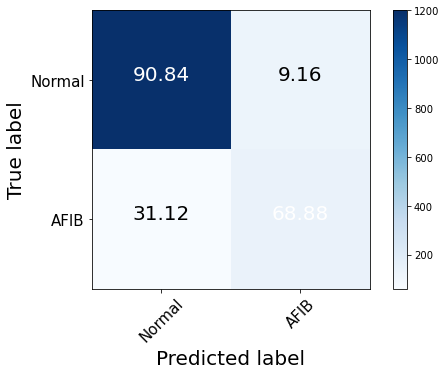

In [78]:
plot_confusion_matrix(cm=cm_stacking_A, target_names=target_names_A)

#### CM XGBOOST (Arrhythmia data)

#### CM ADABOOST (Arrhythmia data)

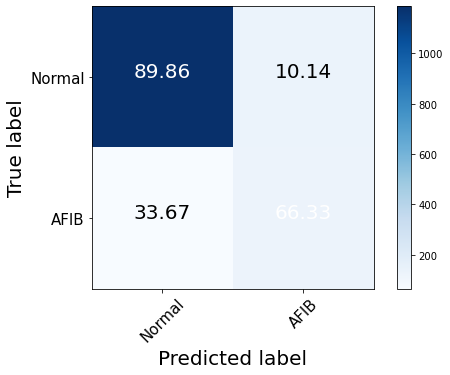

In [79]:
plot_confusion_matrix(cm=cm_xgboost_A, target_names=target_names_A)

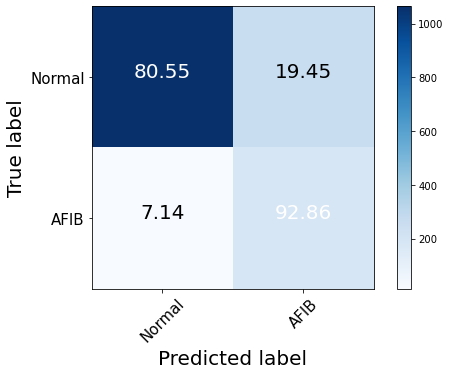

In [80]:
plot_confusion_matrix(cm=cm_adaboost_A, target_names=target_names_A)

## (10.2) RESULTS FOR SEGMENT LENGTH = 20

#### CM SVM (AFIB data)

#### CM DT (AFIB data)

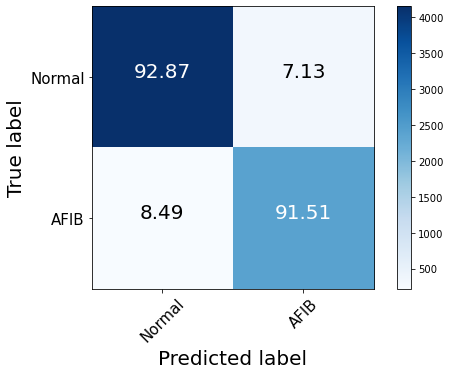

In [60]:
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

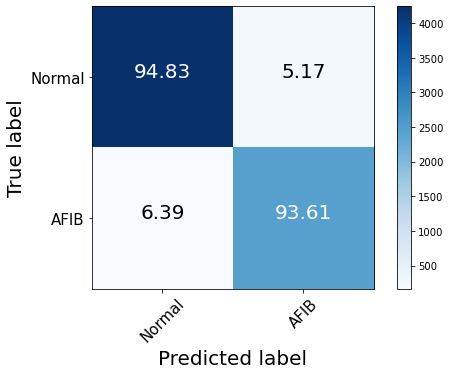

In [61]:
plot_confusion_matrix(cm=cm_dt, target_names=target_names)

#### CM RF (AFIB data)

#### CM STACKING (AFIB data)

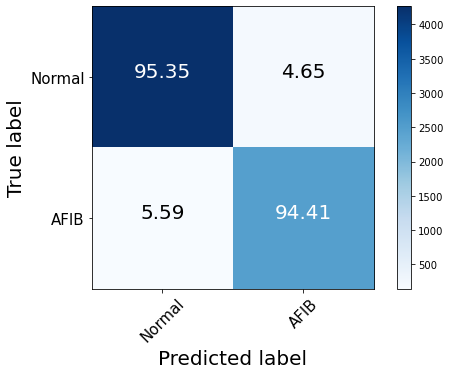

In [62]:
plot_confusion_matrix(cm=cm_rf, target_names=target_names)

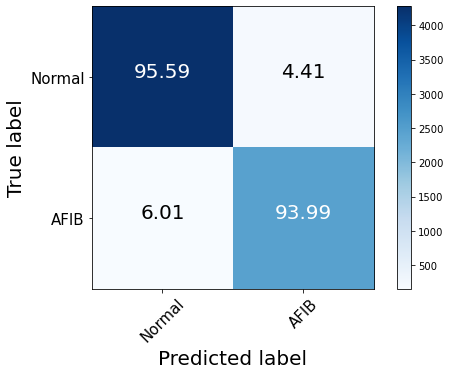

In [63]:
plot_confusion_matrix(cm=cm_stacking, target_names=target_names)

#### CM XGBOOST (AFIB data)

#### CM ADABOOST (AFIB data)

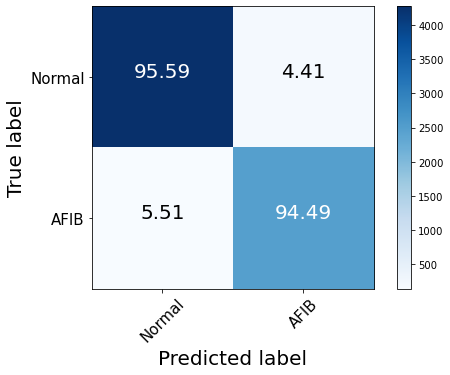

In [64]:
plot_confusion_matrix(cm=cm_xgboost, target_names=target_names)

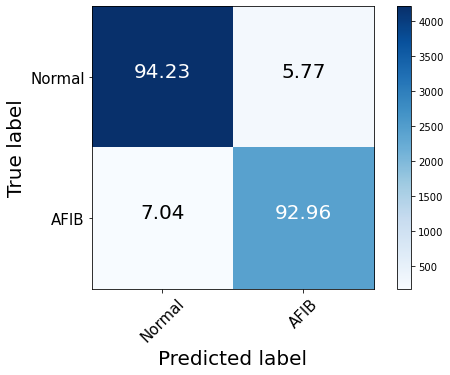

In [65]:
plot_confusion_matrix(cm=cm_adaboost, target_names=target_names)

#### CM SVM (Arrhythmia data)

#### CM DT (Arrhythmia data)

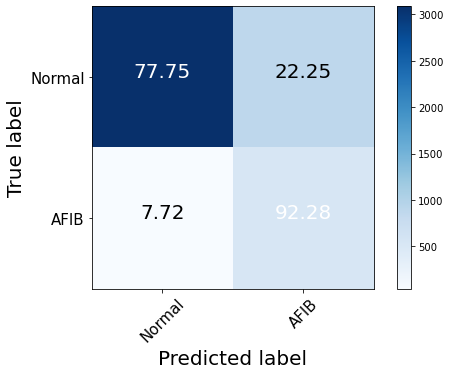

In [66]:
plot_confusion_matrix(cm=cm_svm_A, target_names=target_names_A)

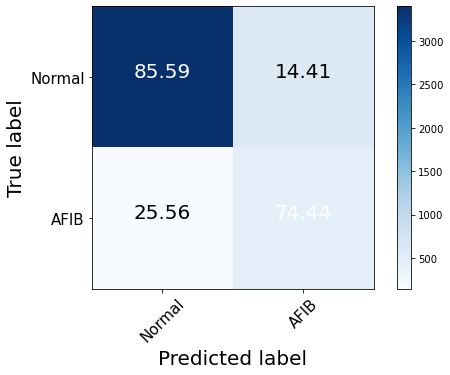

In [67]:
plot_confusion_matrix(cm=cm_dt_A, target_names=target_names_A)

#### CM RF (Arrhythmia data)

#### CM STACKING (Arrhythmia data)

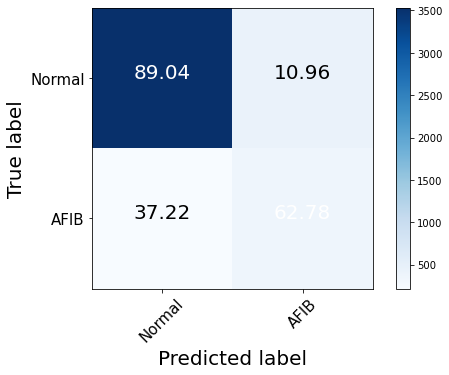

In [68]:
plot_confusion_matrix(cm=cm_rf_A, target_names=target_names_A)

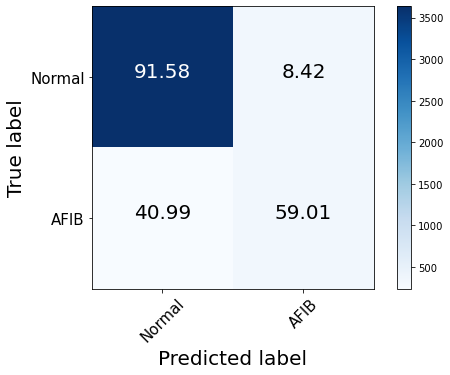

In [69]:
plot_confusion_matrix(cm=cm_stacking_A, target_names=target_names_A)

#### CM XGBOOST (Arrhythmia data)

#### CM ADABOOST (Arrhythmia data)

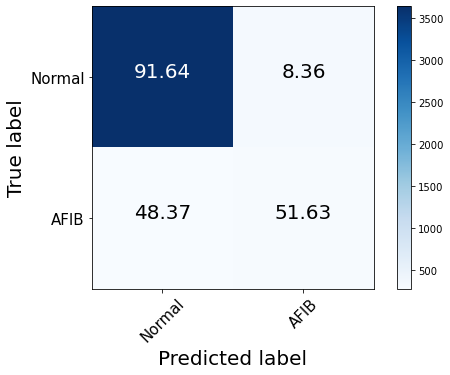

In [70]:
plot_confusion_matrix(cm=cm_xgboost_A, target_names=target_names_A)

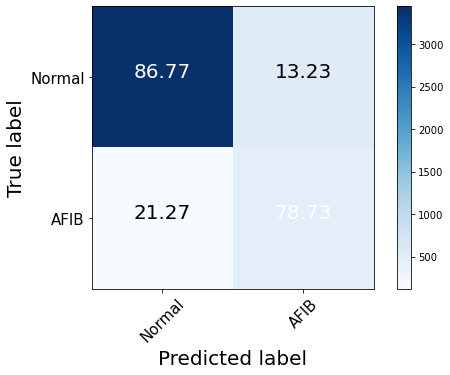

In [71]:
plot_confusion_matrix(cm=cm_adaboost_A, target_names=target_names_A)

## (10.2) RESULTS FOR SEGMENT LENGTH = 10

#### CM SVM (AFIB data)

#### CM DT (AFIB data)

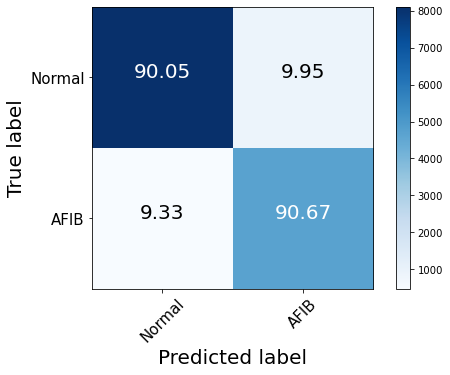

In [65]:
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

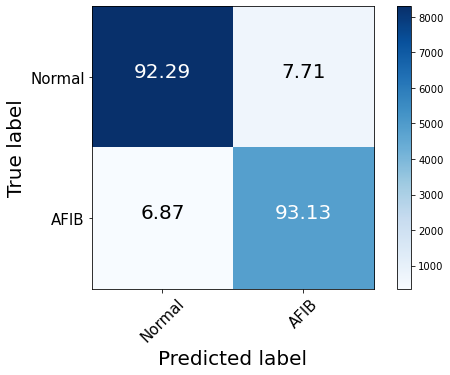

In [66]:
plot_confusion_matrix(cm=cm_dt, target_names=target_names)

#### CM RF (AFIB data)

#### CM STACKING (AFIB data)

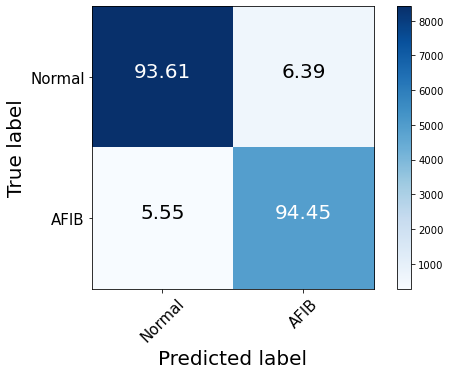

In [67]:
plot_confusion_matrix(cm=cm_rf, target_names=target_names)

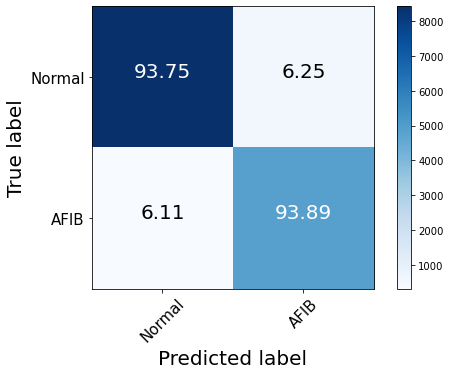

In [68]:
plot_confusion_matrix(cm=cm_stacking, target_names=target_names)

#### CM XGBOOST (AFIB data)

#### CM ADABOOST (AFIB data)

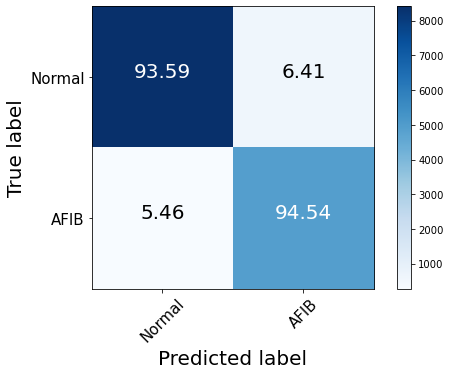

In [69]:
plot_confusion_matrix(cm=cm_xgboost, target_names=target_names)

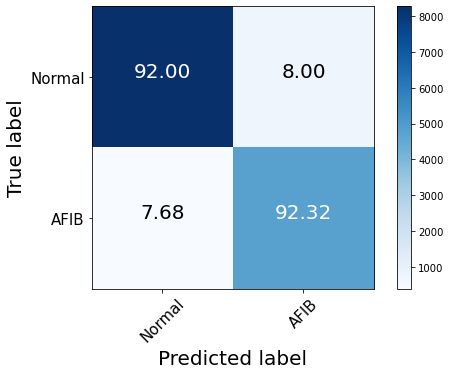

In [70]:
plot_confusion_matrix(cm=cm_adaboost, target_names=target_names)

#### CM SVM (Arrhythmia data)

#### CM DT (Arrhythmia data)

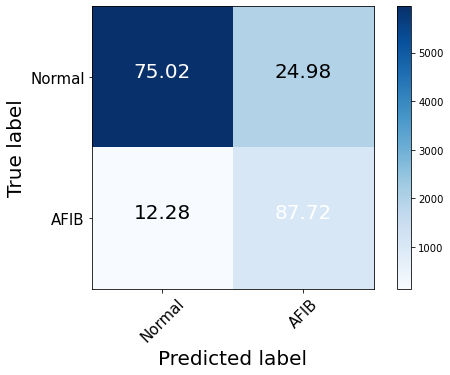

In [71]:
plot_confusion_matrix(cm=cm_svm_A, target_names=target_names_A)

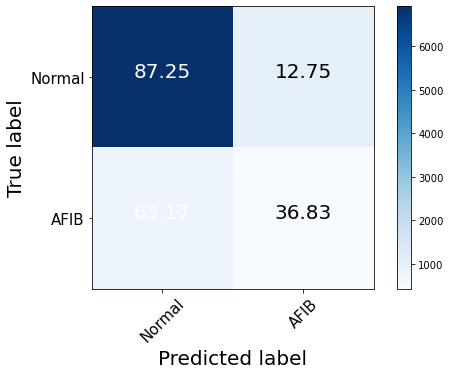

In [72]:
plot_confusion_matrix(cm=cm_dt_A, target_names=target_names_A)

#### CM RF (Arrhythmia data)

#### CM STACKING (Arrhythmia data)

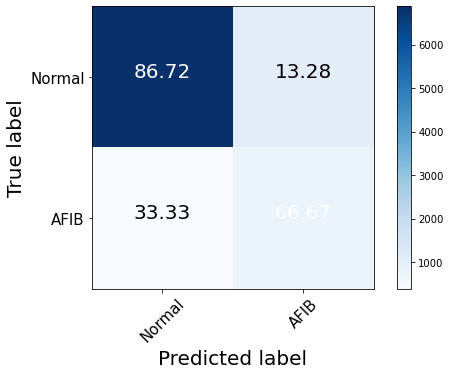

In [73]:
plot_confusion_matrix(cm=cm_rf_A, target_names=target_names_A)

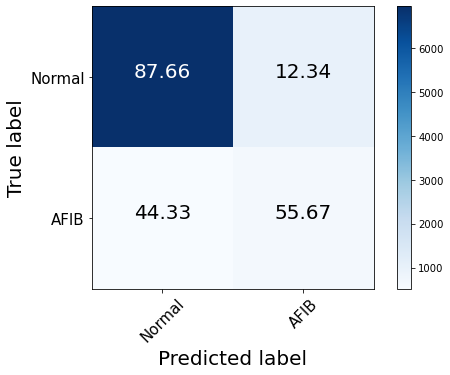

In [74]:
plot_confusion_matrix(cm=cm_stacking_A, target_names=target_names_A)

#### CM XGBOOST (Arrhythmia data)

#### CM ADABOOST (Arrhythmia data)

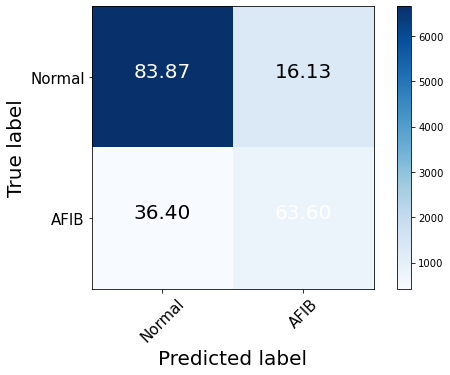

In [75]:
plot_confusion_matrix(cm=cm_xgboost_A, target_names=target_names_A)

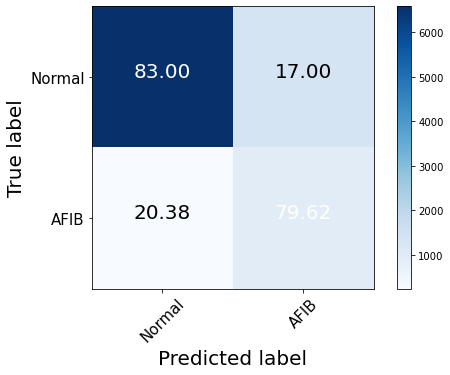

In [76]:
plot_confusion_matrix(cm=cm_adaboost_A, target_names=target_names_A)

# (11) Probability calculations for ROC and AUC metrics (AFIB DATA)
***(Do below code block only ONCE, do it before outputting/printing arrhythmia results)***

In [72]:
from sklearn.metrics import precision_recall_curve

In [73]:
probs_svm = pipeline_svm.predict_proba(X_test)
probs_dt = pipeline_dt.predict_proba(X_test)
probs_rf = pipeline_rf.predict_proba(X_test)

probs_stacking = pipeline_rf.predict_proba(X_test)
probs_xgb = xgb_model.predict_proba(X_test)
probs_ab = adaBoost_clf.predict_proba(X_test)


### Probabilities for the positive outcome is kept
probs_svm = probs_svm[:,1]
probs_dt = probs_dt[:,1]
probs_rf = probs_rf[:,1]

probs_stacking = probs_stacking[:,1]
probs_xgb = probs_xgb[:,1]
probs_ab = probs_ab[:,1]

In [74]:
auc_svm = metrics.roc_auc_score(y_test, probs_svm)
auc_dt = metrics.roc_auc_score(y_test, probs_dt)
auc_rf = metrics.roc_auc_score(y_test, probs_rf)

auc_stacking = metrics.roc_auc_score(y_test, probs_stacking)
auc_xgb = metrics.roc_auc_score(y_test, probs_xgb)
auc_ab = metrics.roc_auc_score(y_test, probs_ab)

In [75]:
fpr_swm, tpr_swm, thresholds_swm = metrics.roc_curve(y_test, probs_svm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, probs_dt)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, probs_rf)

fpr_stacking, tpr_stacking, thresholds_stacking = metrics.roc_curve(y_test, probs_stacking)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, probs_xgb)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, probs_ab)

## (11.1) RESULTS FOR SEGMENT LENGTH = 60

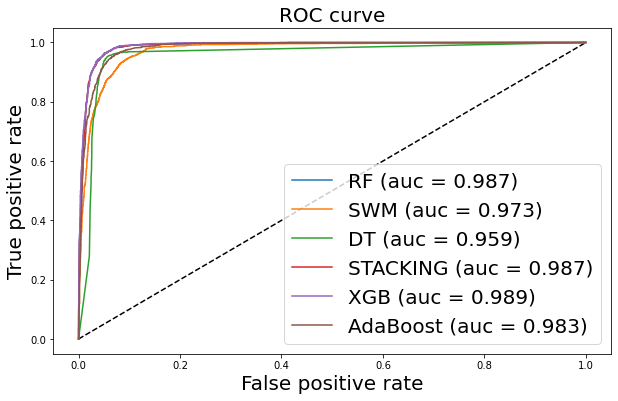

In [75]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

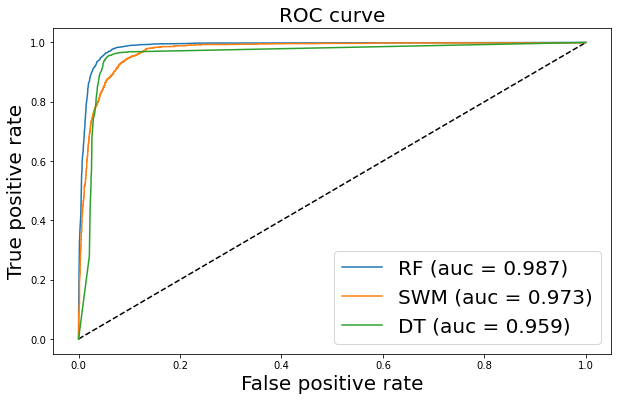

In [76]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

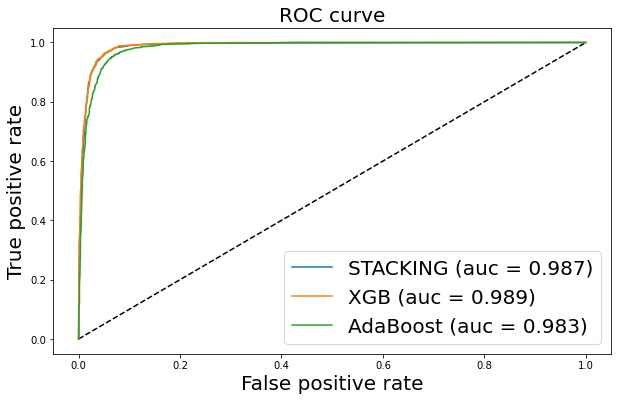

In [77]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

In [78]:
# plt.figure(figsize=(10,6))
# plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color

# plt.plot(fpr_stacking, tpr_stacking, marker='o', label='STACKING (auc = %0.3f)' % auc_stacking)

# plt.xlabel('False positive rate', fontsize=20)
# plt.ylabel('True positive rate', fontsize=20)
# plt.title('ROC curve', fontsize=20)
# plt.legend(loc='best', fontsize=20)
# plt.show()

## (11.2) RESULTS FOR SEGMENT LENGTH = 20

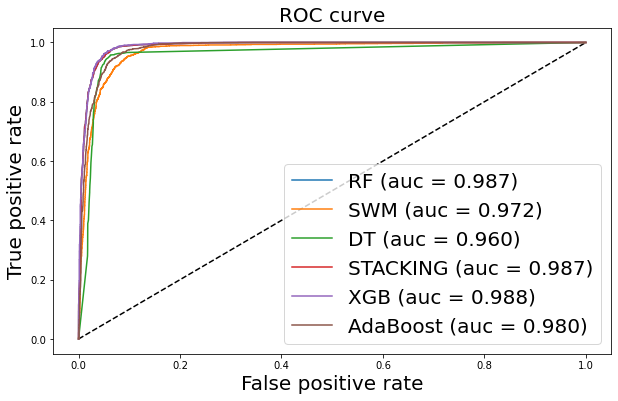

In [76]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

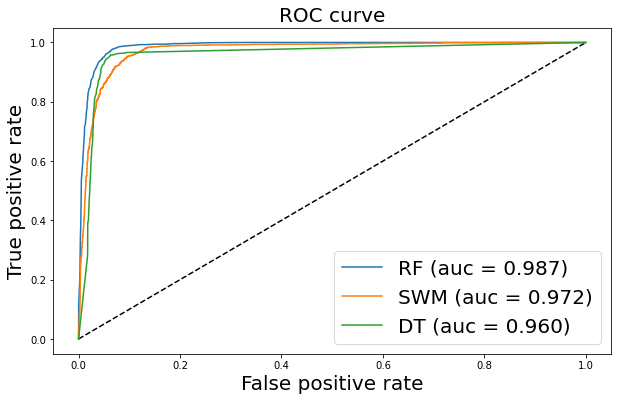

In [77]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

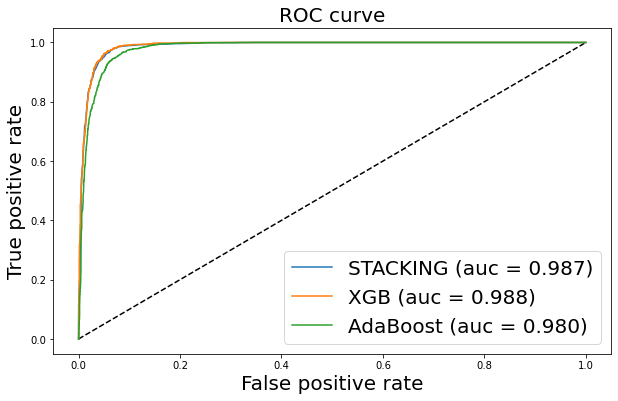

In [78]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

## (11.3) RESULTS FOR SEGMENT LENGTH = 10

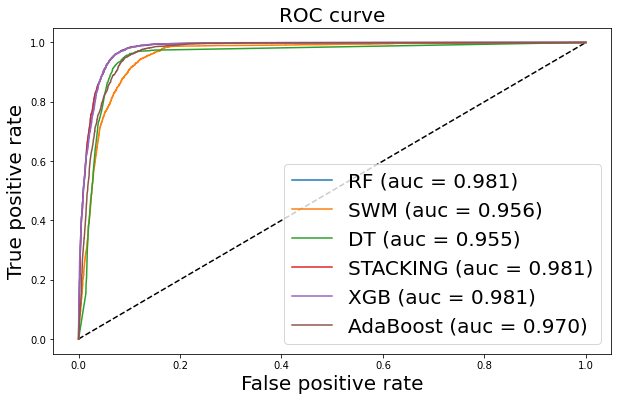

In [81]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

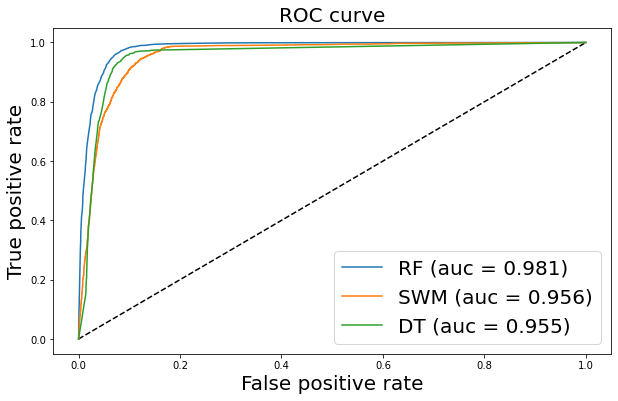

In [82]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

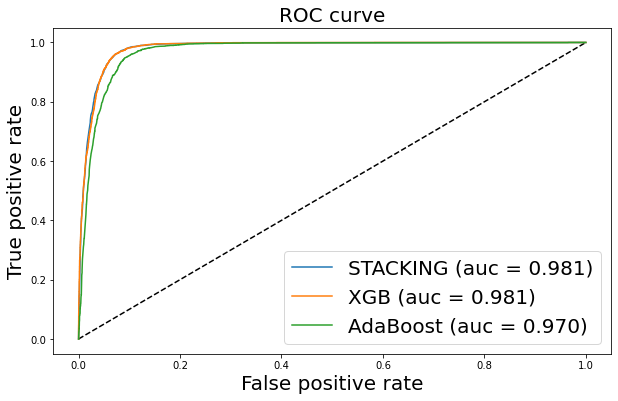

In [83]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

## (12.1) Table overview: scoring = ['test_score']

# Segment amount 10
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92075924 0.84080164 0.84313034 0.79733258 0.78378378] | 0.8371615163468551 |
| Decision tree | [0.92075924 0.89704326 0.86662903 0.85794933 0.79225178] | 0.8669265294016855 |
| Random forest | [0.92111205 0.89450286 0.87396796 0.86535883 0.79514501] | 0.8700173437011935 |
| Stacking classifier | [0.92725092 0.89450286 0.8736857  0.8781314  0.79140498] | 0.8729951696998475 |
|<b> <font color='blue'>xgboost</font> </b> | [0.92823878 0.90275916 0.87989556 0.86931056 0.79810881] | <b>0.875662575135407</b> |  
| adaBoost | [0.93600056 0.91101545 0.8639475 0.86662903 0.78300755] | 0.8721200197506953 |
| Voting Classifier (HARD) | No cross validation | 0.7318656505786058 |
| Voting Classifier (SOFT) | No cross validation | 0.73652272085803 |

### Segment amount 15
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93056732 0.86515665 0.84767651 0.81475601 0.77379062] | 0.8463894204728962 |
| Decision tree | [0.91712532 0.89997883 0.88557214 0.8959458  0.80067746] | 0.8798599109950456 |
| Random forest | [0.91680779 0.89648603 0.88673653 0.89806288 0.806076  ] | 0.8808338457961511 |
| Stacking classifier | [0.92876799 0.90008467 0.88663068 0.91923362 0.80205356] | 0.8873541049504132 |
| <b> <font color='blue'>xgboost</font> </b> | [0.92749788 0.90643522 0.89266434 0.90462581 0.80872235] | <b>0.8879891196547574</b> |
| adaBoost | [0.93681202 0.91151566 0.87339896 0.88800677 0.79919551] | 0.8817857874946883 |
| Voting Classifier (HARD) | No cross validation | 0.8512559977420265 | 
| Voting Classifier (SOFT) | No cross validation | 0.857324301439458 |

### Segment amount 20
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.9322608  0.87552921 0.86014677 0.86704305 0.76979534] | 0.8609550335419408 |
| Decision tree | [0.92012419 0.9062941  0.88399661 0.89188426 0.79971771] | 0.8804033757261079 |
| Random forest | [0.91913633 0.89627434 0.89867344 0.92025406 0.81425547] | 0.8897187273363582 |
| Stacking classifier | [0.93000282 0.90093141 0.893593 0.92971066 0.8052223] | 0.8918920387512547 |
| xgboost | [0.92238216 0.90220152 0.90333051 0.91743119 0.81580805] | 0.8922306869669157 |
| adaBoost | [0.93353091 0.89895569 0.88583122 0.8962597  0.78645025] | 0.8802055520731189 |
| Voting Classifier (HARD) | No cross validation | 0.9486311035845328 | 
| <b> <font color='blue'>Voting Classifier (SOFT)</font> </b> | No cross validation | <b>0.9508890770533446</b> |

### Segment amount 25
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93684953 0.88322455 0.87155963 0.87579393 0.77875794] | 0.8692371180632625 |
| Decision tree | [0.90915505 0.90156994 0.8895554  0.9089626  0.81263232] | 0.8843750626324776 |
| Random forest | [0.91920974 0.90174634 0.90561044 0.92589979 0.81986591]| 0.8944664447396997 |
| Stacking classifier | [0.9310284  0.90421591 0.90137615 0.93772054 0.81351447] | 0.8975710922967126 |
| <b> <font color='blue'>xgboost</font> </b> | [0.92432528 0.90245193 0.91037403 0.92978123 0.82127735] | <b>0.8976419626955051</b>|
| adaBoost | [0.93543835 0.91585818 0.88143966 0.92043049 0.79569513]] | 0.8897723607436501 |
| Voting Classifier (HARD) | No cross validation | 0.8755292125317528 | 
| Voting Classifier (SOFT) | No cross validation | 0.8760937058989556 |

### Segment amount 60
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.9364945  0.89881456 0.87171888 0.90431837 0.80304956]| 0.8828791743907937 |
| Decision tree | [0.91871296 0.92082981 0.9081287  0.92972058 0.82126218] | 0.8997308435374297 |
| Random forest | [0.93183743 0.9322608  0.91447925 0.95004234 0.84709869] |  0.915143700142844 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93776461 0.93141406 0.91320914 0.96062659 0.83566285] | <b>0.9157354498606878</b> |
| xgboost | [0.92929721 0.92675699 0.9195597  0.95300593 0.84498094] | 0.9147201507993463 |
| adaBoost | [0.93141406 0.92421677 0.8954276  0.93903472 0.81745023] | 0.9015086748715454 |
| Voting Classifier (HARD) | No cross validation | 0.6841659610499576 |
| Voting Classifier (SOFT) | No cross validation | 0.6881174146203782 |

### Segment amount 120
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.93480102 0.91363251 0.86198137 0.94157494 0.79830508]| 0.8900589847730307 |
| Decision tree | [0.90770533 0.92548688 0.88484335 0.94834886 0.82966102] | 0.8992090873864435 |
| Random forest | [0.9237934  0.9407282  0.90685859 0.96104996 0.82457627] | 0.9114012830264497 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93734124 0.9407282  0.89585097 0.96951736 0.81694915] | <b>0.9120773834297277</b> |
| xgboost | [0.90855207 0.92887384 0.90347163 0.957663   0.83220339] | 0.9061527863488281 |
| adaBoost | [0.93734124 0.9364945  0.88653683 0.95004234 0.81694915] | 0.9054728110334533 |
| Voting Classifier (HARD) | No cross validation | 0.6699125035280835 |
| Voting Classifier (SOFT) | No cross validation | 0.6783799040361276 |

## (12.2) Table overview: scoring = ['precision_macro']

### Segment amount 10

| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.90901609 0.82913128 0.83751363 0.79804735 0.79050442] | 0.8328425557402422 |
| Decision tree | [0.9091379  0.883873   0.85304185 0.8529422  0.78019421] | 0.8558378305694516 |
| Random forest | [0.91035706 0.88853696 0.85955471 0.85584218 0.78217434] | 0.859293050533927 |
| Stacking classifier | [0.91633424 0.88794029 0.85991648 0.86799686 0.77727863] | 0.8618933018364766 |
|<b> <font color='blue'>xgboost</font> </b> | [0.91781089 0.89484278 0.86629533 0.86209761 0.78692103] | <b>0.8655935272677568</b> |  
| adaBoost | [0.92504207 0.90307636 0.85256869 0.86064788 0.77918339] | 0.8641036786319866 |

### Segment amount 20
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92118499 0.86178046 0.84719857 0.85588685 0.77298434] | 0.8518070430052868 |
| Decision tree | [0.90463721 0.89701568 0.87030209 0.88093824 0.78244283] | 0.8670672086146567 |
| Random forest | [0.90885777 0.89006886 0.88653765 0.90861018 0.80115661] | 0.8790462133976753 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.91872233 0.89636211 0.88322156 0.91809779 0.78941333] | <b>0.8811634252907714</b>|
| xgboost | [0.91116523 0.89531492 0.89047711 0.90500501 0.80120198] | 0.8806328505197618 |
| adaBoost | [0.92199619 0.89281512 0.87258715 0.88516904 0.77376375] | 0.8806328505197618 |

### Segment amount 60
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92501342 0.88580256 0.86103527 0.89190853 0.80146878]| 0.8730457106959557 |
| Decision tree | [0.91315572 0.91338482 0.89238663 0.91800241 0.80481384] | 0.8883486859473735 |
| Random forest | [0.91854214 0.92321429 0.90506758 0.93944582 0.83117845] |  0.9034896542288781 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93226222 0.92338524 0.90520768 0.95202 0.82510008] | <b>0.9075950454507294</b> |
| xgboost | [0.91850551 0.91925385 0.90759045 0.94505354 0.83007033] | 0.9040947345160714 |
| adaBoost | [0.92001345 0.91576532 0.88294673 0.92885481 0.80175305] | 0.8898666720527755 |

### Segment amount 120
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SVM | [0.92325695 0.90212192 0.85257555 0.93080192 0.7934675]| 0.880444768805296 |
| Decision tree | [0.89160153 0.91648605 0.872511   0.94446946 0.81329853] | 0.8876733146580251 |
| <b> <font color='blue'>Random forest</font> </b> | [0.91749582 0.93126885 0.89715865 0.96097628 0.8130069] |  <b>0.9039812993810619</b> |
| Stacking classifier | [0.9283578  0.93419934 0.88484117 0.96806379 0.80084259] | 0.903260937296853 |
| xgboost | [0.89934208 0.92393306 0.89098086 0.95323892 0.81823833] | 0.8971466500331117 |
| adaBoost | [0.92644658 0.92807614 0.87398324 0.943755 0.80205616] | 0.894863424594331 |

## (13) VotingClassifier (additional ensemble results, ONLY FOR SEGMENT = 20, AFIB DATA)

In [79]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[
        ('svm', pipeline_svm), ('dt', pipeline_dt), ('rf', pipeline_rf), 
        ('stacking', clf), ('xgb', xgb_model), ('AdaBoost', adaBoost_clf)], 
        voting='hard', verbose=1)
eclf1 = eclf1.fit(X, y)


eclf2 = VotingClassifier(estimators=[
        ('svm', pipeline_svm), ('dt', pipeline_dt), ('rf', pipeline_rf), 
        ('stacking', clf), ('xgb', xgb_model), ('AdaBoost', adaBoost_clf)],
        voting='soft', verbose=1)
eclf2 = eclf2.fit(X, y)

[Voting] ...................... (1 of 6) Processing svm, total= 2.4min
[Voting] ....................... (2 of 6) Processing dt, total=   0.2s
[Voting] ....................... (3 of 6) Processing rf, total=   9.1s


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ................. (4 of 6) Processing stacking, total=10.5min
[11:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[Voting] ...................... (5 of 6) Processing xgb, total=   1.2s
[Voting] ................. (6 of 6) Processing AdaBoost, total=   1.3s
[Voting] ...................... (1 of 6) Processing svm, total= 2.1min
[Voting] ....................... (2 of 6) Processing dt, total=   0.2s
[Voting] ....................... (3 of 6) Processing rf, total=   8.8s


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ................. (4 of 6) Processing stacking, total=10.5min
[11:44:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[Voting] ...................... (5 of 6) Processing xgb, total=   1.5s
[Voting] ................. (6 of 6) Processing AdaBoost, total=   1.5s


In [80]:
print("---------TESTING----------")
print(eclf1.score(X_test, y_test))
print(eclf2.score(X_test, y_test))
print("---------TRAINING----------")
print(eclf1.score(X_train, y_train))
print(eclf2.score(X_train, y_train))

---------TESTING----------
0.9714930849562518
0.9750211685012701
---------TRAINING----------
0.9746312892526992
0.9775598052360455


In [81]:
### HARD
y_pred_voting_clf_hard = eclf1.predict(X_test)
cm_voting_clf_hard = confusion_matrix(y_test, y_pred_voting_clf_hard)
### SOFT
y_pred_voting_clf_soft = eclf2.predict(X_test)
cm_voting_clf_soft = confusion_matrix(y_test, y_pred_voting_clf_soft)

#### CM VOTING SOFT

#### CM VOTING HARD

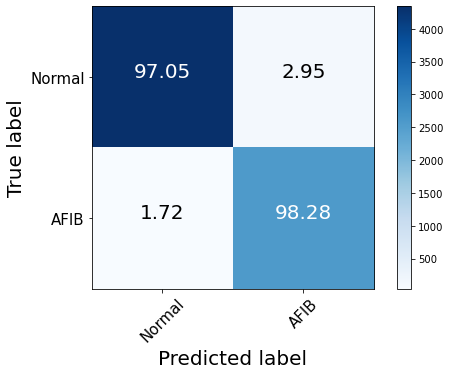

In [82]:
plot_confusion_matrix(cm=cm_voting_clf_soft, target_names=target_names)

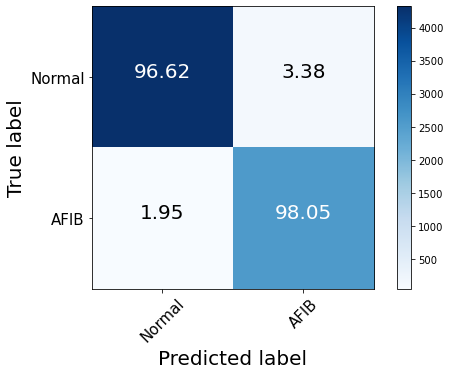

In [83]:
plot_confusion_matrix(cm=cm_voting_clf_hard, target_names=target_names)

In [84]:
probs_voting_soft = eclf2.predict_proba(X_test)
probs_voting_soft = probs_voting_soft[:,1]
auc_voting_soft = metrics.roc_auc_score(y_test, probs_voting_soft)
fpr_voting, tpr_voting, thresholds_voting = metrics.roc_curve(y_test, probs_voting_soft)

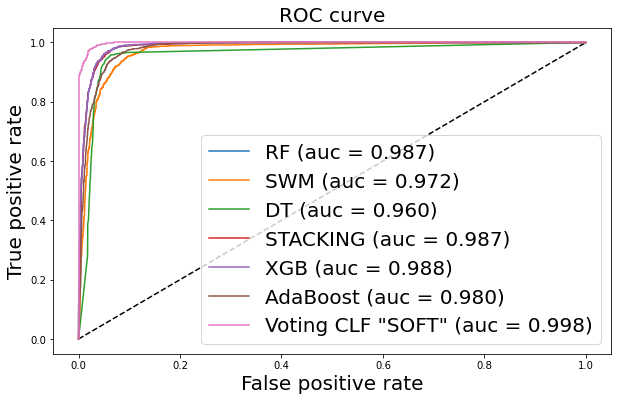

In [85]:
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AdaBoost (auc = %0.3f)' % auc_ab)

plt.plot(fpr_voting, tpr_voting, label='Voting CLF "SOFT" (auc = %0.3f)' % auc_voting_soft)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

### GridsearchCV (combinations of parameter values are evaluated)

In [ ]:
from sklearn.model_selection import GridSearchCV
pipeline_svm.get_params().keys()

In [ ]:
# from time import time
# t0 = time()
# parameters = {'svm_classifier__C':[1, 10, 20], 'svm_classifier__kernel':['linear', 'rbf']}
# #parameters = {'rf_classifier__n_estimators': [200, 700], 'rf_classifier__max_features': ['auto', 'sqrt', 'log2'], 'rf_classifier__criterion':['gini','entropy']}
# clf = GridSearchCV(pipeline_swm, parameters, cv=5)
# clf.fit(X_train, y_train)
# print("done in %0.3fs" % (time() - t0))

In [ ]:
#df_search_results = pd.DataFrame(clf.cv_results_)
#df_search_results

In [ ]:
#df_search_results[['param_rf_classifier__criterion', 'param_rf_classifier__max_depth', 'mean_test_score']]
#clf.best_params_